# Analysing the annotations 
This analysis includes:

1. describing the POIs using OSM tags
2. describing the relationship between the OSM tags and the topics for matches
3. finding patterns in unmatched topics
4. comparing the matched OSM records with their surrounding features (not selected - including and excluding the route)

In [1]:
# working with files
import os.path
# sys
import sys
# warning off
import warnings
# IO
import json

# requests
import requests

# dataframe 
import numpy as np
import pandas as pd
import geopandas as gpd


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# logging
from loguru import logger

# set logger level
logger.remove(0)
logger.add(sys.stderr, level="INFO")

warnings.filterwarnings("ignore")

## 2.1. Walking Map Dataset

Creating a detailed dataframe of all POIs, their description, topic and sub-topic and their point-based representation.

In [2]:
# dataset:

# 0. Geodataframe of all POIs
with open('dataset/walkingmaps.json', 'r', encoding='utf-8') as fp:
    dataset = json.load(fp)

data_structure = {
    'record_id': [], 'record_title':[], 'record_description':[],
    'poi_title':[], 'poi_summary':[], 'latitude': [], 'longitude': []}

for record_id, record in enumerate(dataset):
    if 'pois' in record.keys() and len(record['pois']) > 0:
        for poi in record['pois']:
            data_structure['record_id'].append(record_id)
            data_structure['record_title'].append(record['title'])
            data_structure['record_description'].append(record['description'])
            data_structure['poi_title'].append(poi['title'])
            data_structure['poi_summary'].append(poi['summary'])
            data_structure['latitude'].append(poi['lat'])
            data_structure['longitude'].append(poi['lng'])

df = pd.DataFrame(data_structure)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

print(gdf.head())

# 1. POI - topic
poi_classified = pd.read_csv('outputs/dataframes/refined-topic-poi-description-classified.csv')
poi_classified.head()

   record_id                                       record_title  \
0          1  Fairhaven to Aireys Inlet Walk created by tedm...   
1          1  Fairhaven to Aireys Inlet Walk created by tedm...   
2          1  Fairhaven to Aireys Inlet Walk created by tedm...   
3          1  Fairhaven to Aireys Inlet Walk created by tedm...   
4          1  Fairhaven to Aireys Inlet Walk created by tedm...   

                                  record_description  \
0  Apart from the points of interested listed, he...   
1  Apart from the points of interested listed, he...   
2  Apart from the points of interested listed, he...   
3  Apart from the points of interested listed, he...   
4  Apart from the points of interested listed, he...   

                         poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                               

,Unnamed: 0,index,topic,document,is_found,class,Count,Name,Representation,Representative_Docs,Class ID,Class,Subclass
0,0,0,2,Surf Life Saving Club: is a well known surf be...,False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
1,1,1,2,"Beach walk: From Sprout Creek, , , to the bott...",False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
2,2,3,2,Sand dunes: The beautiful rolling sand dune sh...,False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
3,3,96,2,"Surf' up: A good spot to watch the surf, have ...",False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
4,4,99,2,"Heading down to the beach: Follow the track, w...",False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks


In [3]:
gdf.reset_index()
detailed_df = pd.merge(gdf.reset_index(), poi_classified, left_on='index', right_on='index', how='inner')
detailed_df.head()

,index,record_id,record_title,record_description,poi_title,poi_summary,latitude,longitude,geometry,Unnamed: 0,...,document,is_found,class,Count,Name,Representation,Representative_Docs,Class ID,Class,Subclass
0,0,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876),0,...,Surf Life Saving Club: is a well known surf be...,False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
1,1,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854),1,...,"Beach walk: From Sprout Creek, , , to the bott...",False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
2,2,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846),171,...,Rock pools: See what sort of shell and stone y...,False,NaN,153,1_bird_duck_birdlife_ducks,"['bird', 'duck', 'birdlife', 'ducks', 'feng', ...",['Black s: Keep an eye out for the birdlife at...,0,nature,flora and funa
3,3,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842),2,...,Sand dunes: The beautiful rolling sand dune sh...,False,NaN,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,0,nature,natural landmarks
4,4,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839),380,...,Painkalac Creek: The creek sete from and form ...,False,NaN,37,23_creek_frost_leary_running,"['creek', 'frost', 'leary', 'running', 'toomuc...",['Creek: The reserve ha two creek running thro...,0,nature,natural landmarks


In [10]:
import geopy.distance

distances = []
# how many walks are closed 
for r in dataset:
    first_point = r['pathDetails'][0]
    last_point = r['pathDetails'][-1]
    d = geopy.distance.geodesic((first_point['lat'], first_point['lng']), 
                            (last_point['lat'], last_point['lng'])).km
    distances.append(d*1000)

sorted(distances)

[0.4171506804730554,
 0.6815437925282533,
 0.6884058719894034,
 0.7142585947059268,
 0.74434946146078,
 0.9393607674712819,
 1.044959508684378,
 1.0852820618533316,
 1.1436086538508226,
 1.2065059566791478,
 1.2475699083392193,
 1.3541450760807037,
 1.4399136522027147,
 1.4520782629500248,
 1.5523175468836001,
 1.5937210380267133,
 1.6905194057099062,
 1.792324102743417,
 1.8571070893598784,
 1.937152418483248,
 1.9476446392717965,
 2.066752692274065,
 2.131569614358033,
 2.182600651351965,
 2.2093548458885,
 2.4428240959658107,
 2.473413037286555,
 2.52138736117353,
 2.548266791116797,
 2.782524508191686,
 2.952858751458949,
 2.966361035545448,
 2.975439621351388,
 3.121965537920632,
 3.229294177467397,
 3.3552140594857107,
 3.47709432448056,
 3.5285243714479417,
 3.551391379001496,
 3.6327617723190833,
 3.6680351972332943,
 3.7611644556714285,
 3.7792445068178244,
 3.955461527619568,
 4.041675174125051,
 4.098461232699732,
 4.135458944233644,
 4.138615177811058,
 4.165048674231627,
 

In [18]:
len([d for d in distances if d < 100])

203

In [15]:
len(distances)

387

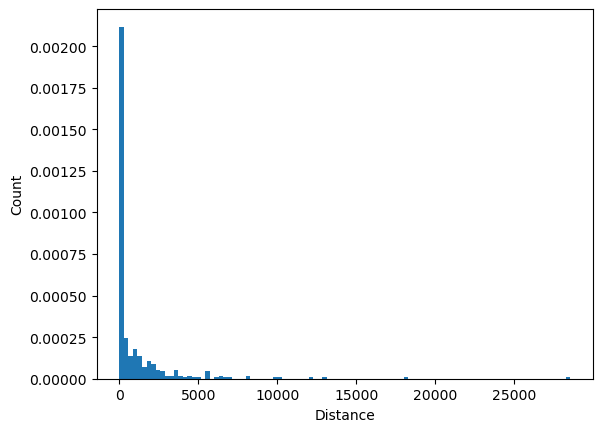

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.hist(distances, density=True, bins=100)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Distance');

## 2.2 Annotations

Loading and parsing the annotations for each point of interest

In [4]:
# reading annotation files
with open('dataset/annotations.json') as fp:
    raw_annotations = json.load(fp)


annotations = {}
for annotation_record in raw_annotations:
    page = None
    annotation = []
    for info in annotation_record:
        if 'page' in info.keys():
            page = str(info['page'])
        elif 'type' in info.keys() and 'osm_id' in info.keys():
            annotation.append(f"{info['type']}:{info['osm_id']}")
        else:
            logger.error(f'structural issues: {info}')

    if page is not None:
        annotations[page] = annotation

logger.info(f'total annotations: {len(annotations)}')

2024-12-14 19:20:15.464 | INFO     | __main__:<module>:21 - total annotations: 4386


In [5]:
annotations

{'0': ['way:1089591567'],
 '1': ['way:1007494584'],
 '2': [],
 '3': [],
 '4': ['way:30501938', 'way:30501933'],
 '5': ['relation:9212157'],
 '6': ['way:69366108', 'way:69366081'],
 '7': ['node:4583492091',
  'node:11158854688',
  'node:11158854687',
  'node:11158854665'],
 '8': ['node:3621405496'],
 '9': [],
 '10': ['node:831201041'],
 '11': [],
 '12': ['way:26564416'],
 '13': ['way:49961266'],
 '14': ['way:26564392', 'node:6758200723'],
 '15': ['node:5371634608'],
 '16': ['node:7228362154', 'way:32710391'],
 '17': ['way:435967756'],
 '18': ['way:436339688',
  'way:436339689',
  'way:436339690',
  'way:1215583957',
  'way:436339691',
  'way:436339692',
  'way:1215583958',
  'way:436339693',
  'way:1215583959',
  'way:436339694',
  'way:436339695',
  'way:1215583956',
  'way:436339696',
  'way:436339697',
  'way:1215583960',
  'way:436339698'],
 '19': [],
 '21': ['node:368393200'],
 '22': ['way:4817074'],
 '23': ['relation:6623509', 'way:4817059', 'node:6810298878'],
 '24': ['relation:6

In [6]:
# download all information from OSM for these matched POIs
api_endpoint = 'https://www.openstreetmap.org/api/0.6/{0}/{1}.json'
headers = {"Content-Type": "application/json; charset=utf-8"}

def get_info(info):
    if info.lower() == 'flag':
        logger.warning('still a flagged record')
        return {}
    otype = info.lower().split(':')[0]
    oid = info.lower().split(':')[1]
    if otype not in ['node', 'way', 'relation']:
        logger.warning('wrong type - {}'.format(otype))
    resp = requests.get(api_endpoint.format(otype, oid), headers=headers)
    return resp.json()

get_info('way:26564416')  # testing

{'version': '0.6',
 'generator': 'openstreetmap-cgimap 2.0.1 (541736 spike-08.openstreetmap.org)',
 'copyright': 'OpenStreetMap and contributors',
 'attribution': 'http://www.openstreetmap.org/copyright',
 'license': 'http://opendatacommons.org/licenses/odbl/1-0/',
 'elements': [{'type': 'way',
   'id': 26564416,
   'timestamp': '2022-11-08T23:44:08Z',
   'version': 13,
   'changeset': 128661596,
   'user': 'MapAbility',
   'uid': 13782447,
   'nodes': [291210982,
    291210974,
    291210988,
    291210981,
    291210998,
    5651652284,
    5651652286,
    5651652285,
    291210982],
   'tags': {'brand': 'YMCA',
    'brand:wikidata': 'Q157169',
    'building': 'yes',
    'heritage': 'yes',
    'leisure': 'sports_centre',
    'name': 'Melbourne City Baths',
    'operator': 'ymca',
    'sport': 'swimming',
    'wikidata': 'Q2786840',
    'wikipedia': 'en:City Baths, Melbourne'}}]}

In [7]:
# Error log for later checkup:
# 2/4386 [00:03<1:56:13,  1.59s/it]2024-08-03 10:03:47.158 | ERROR    | __main__:<module>:12 - 4:way:30501938 error
# 103/4386 [02:56<2:25:38,  2.04s/it]2024-08-03 10:06:40.457 | ERROR    | __main__:<module>:12 - 104:node:flag error
# 104/4386 [02:57<2:05:28,  1.76s/it]2024-08-03 10:06:41.566 | ERROR    | __main__:<module>:12 - 105:node:flag error
# 123/4386 [03:40<2:34:06,  2.17s/it]2024-08-03 10:07:24.255 | ERROR    | __main__:<module>:12 - 129:way:1008233190 error
# 129/4386 [03:41<1:21:47,  1.15s/it]2024-08-03 10:07:25.332 | ERROR    | __main__:<module>:12 - 130:way:1008233190 error
# 130/4386 [03:42<1:21:11,  1.14s/it]2024-08-03 10:07:26.427 | ERROR    | __main__:<module>:12 - 131:way:1008233190 error
# 133/4386 [03:46<1:30:56,  1.28s/it]2024-08-03 10:07:30.706 | ERROR    | __main__:<module>:12 - 136:node:flag error
# 136/4386 [03:47<1:01:56,  1.14it/s]2024-08-03 10:07:31.804 | ERROR    | __main__:<module>:12 - 137:node:flag error
# 205/4386 [05:18<2:05:45,  1.80s/it]2024-08-03 10:09:02.044 | ERROR    | __main__:<module>:12 - 207:node:flag error
# 231/4386 [05:39<1:01:43,  1.12it/s]2024-08-03 10:09:23.175 | ERROR    | __main__:<module>:12 - 234:node:flag error
# 270/4386 [06:33<1:39:43,  1.45s/it]2024-08-03 10:10:17.014 | ERROR    | __main__:<module>:12 - 271:node:flag error
# 297/4386 [07:22<1:50:19,  1.62s/it]2024-08-03 10:11:06.058 | ERROR    | __main__:<module>:12 - 308:node:flag error
# 457/4386 [10:10<1:13:11,  1.12s/it]2024-08-03 10:13:54.346 | ERROR    | __main__:<module>:12 - 459:node:flag error
# 459/4386 [10:11<1:01:12,  1.07it/s]2024-08-03 10:13:55.578 | ERROR    | __main__:<module>:12 - 460:node:flag error
# 661/4386 [13:33<1:21:48,  1.32s/it]2024-08-03 10:17:17.132 | ERROR    | __main__:<module>:12 - 662:node:8850035047 error
# 712/4386 [14:45<1:57:02,  1.91s/it]2024-08-03 10:18:29.385 | ERROR    | __main__:<module>:12 - 713:node:flag error
# 729/4386 [15:06<1:01:31,  1.01s/it]2024-08-03 10:18:50.404 | ERROR    | __main__:<module>:12 - 731:way:1009404233 error
# 966/4386 [20:11<1:03:43,  1.12s/it]2024-08-03 10:23:57.022 | ERROR    | __main__:<module>:12 - 970:node:316598549 error
# 1208/4386 [25:12<15:44,  3.37it/s]2024-08-03 10:28:56.058 | ERROR    | __main__:<module>:12 - 1209:way:277584589 error
# 1648/4386 [33:41<2:05:48,  2.76s/it]2024-08-03 10:37:25.365 | ERROR    | __main__:<module>:12 - 1649:node:2397398815 error
# 1653/4386 [33:53<1:42:39,  2.25s/it]2024-08-03 10:37:37.538 | ERROR    | __main__:<module>:12 - 1654:node:flag error
# 1778/4386 [36:03<1:01:09,  1.41s/it]2024-08-03 10:39:47.312 | ERROR    | __main__:<module>:12 - 1779:way:490502525 error
# 2024/4386 [40:52<41:47,  1.06s/it]2024-08-03 10:44:36.498 | ERROR    | __main__:<module>:12 - 2028:way:1009406415 error
# 2030/4386 [40:54<28:58,  1.36it/s]2024-08-03 10:44:38.648 | ERROR    | __main__:<module>:12 - 2032:way:1009406415 error
# 2402/4386 [47:27<53:14,  1.61s/it]2024-08-03 10:51:11.918 | ERROR    | __main__:<module>:12 - 2403:node:2397398815 error
# 2472/4386 [48:56<26:37,  1.20it/s]2024-08-03 10:52:40.128 | ERROR    | __main__:<module>:12 - 2473:way: 12283703 error
# 3052/4386 [1:01:32<33:49,  1.52s/it]2024-08-03 11:05:16.546 | ERROR    | __main__:<module>:12 - 3054:node:4469652313 error
# 3270/4386 [1:05:39<12:45,  1.46it/s]2024-08-03 11:09:23.517 | ERROR    | __main__:<module>:12 - 3272:way:1007170487 error
# 3484/4386 [1:09:48<19:36,  1.30s/it]2024-08-03 11:13:35.092 | ERROR    | __main__:<module>:12 - 3485:way:799508737 error
# 2024-08-03 11:13:36.200 | ERROR    | __main__:<module>:12 - 3485:way:934955492 error
# 3582/4386 [1:11:43<22:12,  1.66s/it]2024-08-03 11:15:27.897 | ERROR    | __main__:<module>:12 - 3588:node:4682651695 error
# 3704/4386 [1:13:37<15:16,  1.34s/it]2024-08-03 11:17:21.901 | ERROR    | __main__:<module>:12 - 3710:node:3838183016 error
# 4386/4386 [1:23:20<00:00,  1.14s/it]

In [8]:
from tqdm import tqdm
import time 

if os.path.isfile('outputs/annotations_details_osm_info.json'):
    with open('outputs/annotations_details_osm_info.json') as fp:
        osm_detailed_information = json.load(fp)

    logger.info('annotation details are loaded from cache')
else:
    logger.info('annotation cache cannot be found, will fetch the results from OSM')
    # save all information about the matched records
    osm_detailed_information = {}
    for poi_id, matches in tqdm(annotations.items()):
        osm_detailed_information[poi_id] = {}
        for match in matches:
            try:
                osm_detailed_information[poi_id][match] = get_info(match)
                time.sleep(0.5)  # for polite crawling
            except Exception as e:
                logger.error(f'{poi_id}:{match} error', exc_info=True)
    with open('outputs/annotations_details_osm_info.json', 'w', encoding='utf-8') as fp:
        json.dump(osm_detailed_information, fp)
    logger.info('annotation details are saved and will be loaded the later runs...')

2024-12-14 19:20:23.935 | INFO     | __main__:<module>:8 - annotation details are loaded from cache


In [9]:
poi_matched_and_founds = [p for p,v in osm_detailed_information.items() if len(v) > 0]
poi_not_matched = [p for p in osm_detailed_information.keys() if p not in poi_matched_and_founds]
osm_matched_and_founds = [len(v) for v in osm_detailed_information.values()]

logger.info(f'\nannotation details are available for: {sum(osm_matched_and_founds)} osm entities out of {len(poi_matched_and_founds)} matched pois\nNote that the relationship is not one to one')

2024-12-14 19:20:26.503 | INFO     | __main__:<module>:5 - 
annotation details are available for: 3255 osm entities out of 2379 matched pois
Note that the relationship is not one to one


In [10]:
osm_detailed_information['1']

{'way:1007494584': {'version': '0.6',
  'generator': 'CGImap 0.9.3 (987906 spike-08.openstreetmap.org)',
  'copyright': 'OpenStreetMap and contributors',
  'attribution': 'http://www.openstreetmap.org/copyright',
  'license': 'http://opendatacommons.org/licenses/odbl/1-0/',
  'elements': [{'type': 'way',
    'id': 1007494584,
    'timestamp': '2024-06-29T04:38:50Z',
    'version': 3,
    'changeset': 153317242,
    'user': 'Fizzie41',
    'uid': 461130,
    'nodes': [9294714213,
     9294714214,
     9294714215,
     9294714216,
     9294780017,
     9294780018,
     9294780019,
     9294780020,
     9294780021,
     9294780022,
     9294780023,
     9294780024,
     9294780025,
     9294780026,
     9294780027,
     9294780028,
     9294780029,
     9294780030,
     9294780031,
     9294780032,
     9294780033,
     9294780034,
     9294780035,
     9294780036,
     9294780037,
     9294780038,
     9294780039,
     9294780040,
     9294780041,
     9294780042,
     9294780043,
     9

## 2.3 Nearby OSM features
This will load already stored nearby features - see the `2. annotation analysis.ipynb` for more details.

In [11]:
# load nearby features:
def get_osm_poi_nearby(key):
    logger.debug('key: {}'.format(key))
    dist_threshold = 200  # for normal cases
    if os.path.isfile('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold)):
        features =  gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold))
    else:
        features =  gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, 1000))
    features = features.to_crs('EPSG:32755')
    return features

def get_osm_pois_nearby(poi_keys):
    osm_pois = {}
    for key in tqdm(poi_keys):
        features = get_osm_poi_nearby(key)
        osm_pois[key] = features
    return osm_pois

matched_nearby_features = get_osm_pois_nearby(poi_matched_and_founds[:5])
unmatched_nearby_features = get_osm_pois_nearby(poi_not_matched[:5])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


## 3. Topics/SubClass/Class Relation to OSM KeyValues

To study how POIs belonging to each cateogries is described in OSM

Can we find from OSM key values which kind of POI we are dealing with? - Context: we already know about the quality issue of OSM attributes and if the POIs are well document (community care about them), we can expect a good coverage of attribute information!)

In [12]:
detailed_df.columns

Index(['index', 'record_id', 'record_title', 'record_description', 'poi_title',
       'poi_summary', 'latitude', 'longitude', 'geometry', 'Unnamed: 0',
       'topic', 'document', 'is_found', 'class', 'Class', 'Class ID', 'Count',
       'Name', 'Representation', 'Representative_Docs', 'Subclass'],
      dtype='object')

In [13]:
filtered_df = detailed_df[['index', 'record_id', 'topic', 'Class ID', 'Class', 'Subclass']]
filtered_df.head()
# 4 concepts are captured about POIs in this dataframe
# Points of interest: index column
    # 1. Leisure walk: record_id column
    # 2. detailed topic: topic column
    # 3. Sub-class (aggregation of topics): Subclass
    # 4. Class (aggregation of subclasses): Class

,index,record_id,topic,Class ID,Class,Subclass
0,0,1,2,0.0,nature,natural landmarks
1,1,1,2,0.0,nature,natural landmarks
2,2,1,1,0.0,nature,flora and funa
3,3,1,2,0.0,nature,natural landmarks
4,4,1,23,0.0,nature,natural landmarks


In [14]:
from string import digits

def get_all_key_values(poi_id):
    if poi_id not in osm_detailed_information.keys():
        logger.info(f'missing key in OSM details: {poi_id}')
        return []
    all_info = osm_detailed_information[poi_id]
    tags = []
    for oid, values in all_info.items():
        if 'elements' in values.keys():
            tmp_tags = [[k+' '+v for k,v in elem['tags'].items() if 'name' not in k] for elem in values['elements'] if 'tags' in elem]
            tmp_tags = [t for tag in tmp_tags for t in tag]
            tags.extend(tmp_tags)
    return remove_digits(' '.join(tags))

def remove_digits(s):
    remove_digits = str.maketrans('', '', digits)
    res = s.translate(remove_digits)
    return res


get_all_key_values('5')
# osm_detailed_information['1']['way:1007494584']['elements']

'boundary protected_area iucn_level III leisure nature_reserve operator Victorian Department of Environment, Land, Water and Planning protect_class  protection_title Marine Sanctuary ref:capad:pa_id  ref:vicmap:prims_id  source CAPAD start_date -- type boundary'

In [15]:
filtered_df['tags'] = filtered_df.apply(lambda row: get_all_key_values(str(row['index'])), axis=1)
filtered_df.head()

2024-12-14 19:21:05.351 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 20
2024-12-14 19:21:05.395 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3551
2024-12-14 19:21:05.396 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3552
2024-12-14 19:21:05.397 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3553
2024-12-14 19:21:05.397 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3554
2024-12-14 19:21:05.397 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3555


,index,record_id,topic,Class ID,Class,Subclass,tags
0,0,1,2,0.0,nature,natural landmarks,addr:housenumber addr:postcode addr:street G...
1,1,1,2,0.0,nature,natural landmarks,natural beach surface sand
2,2,1,1,0.0,nature,flora and funa,
3,3,1,2,0.0,nature,natural landmarks,
4,4,1,23,0.0,nature,natural landmarks,waterway stream


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

labelled_filtered_df = filtered_df[filtered_df['Class'] != 'unknown']

labelled_filtered_df['class_id'] = labelled_filtered_df['Class'].astype('category').cat.codes
target = labelled_filtered_df['class_id']
data = labelled_filtered_df['tags'].astype(str)

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=432)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X_train = vectorizer.fit_transform(data_train)
X_test =  vectorizer.transform(data_test)

In [17]:
feature_names = vectorizer.get_feature_names_out()

In [18]:
feature_names

array(['abandoned', 'access', 'addr', 'address', 'amenity', 'anglican',
       'arch', 'architect', 'area', 'arts_centre', 'artwork',
       'artwork_type', 'asphalt', 'attraction', 'au', 'australia',
       'australian_football', 'avenue', 'backrest', 'bakery', 'ballarat',
       'bare_rock', 'barrier', 'basketball', 'bay', 'bbq', 'beach',
       'bellair', 'bench', 'bendigo', 'bicycle', 'bin', 'bing', 'bmx',
       'board', 'boardwalk', 'boat', 'boulevard', 'boundary', 'bourke',
       'bowls', 'branch', 'brand', 'bridge', 'building', 'bus',
       'bus_stop', 'buses', 'cafe', 'capad', 'caravan_site', 'carlton',
       'category', 'cathedral', 'catholic', 'cemetery', 'centre',
       'changing_table', 'check_date', 'christian', 'church', 'city',
       'club', 'colour', 'com', 'community', 'community_centre',
       'compacted', 'concrete', 'construction', 'contact', 'council',
       'country', 'courthouse', 'covered', 'created_by', 'cricket',
       'cuisine', 'cultural_significanc

In [19]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
cv_results = cross_validate(clf, X_train, target_train, cv=10, return_estimator=True)

sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [20]:
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

array([0.6       , 0.5880597 , 0.54029851, 0.56119403, 0.5880597 ,
       0.55522388, 0.58083832, 0.57185629, 0.56886228, 0.52994012])

In [21]:
pred = clf.predict(X_test)

In [23]:
target_names

['activities', 'nature', 'society', 'transport']

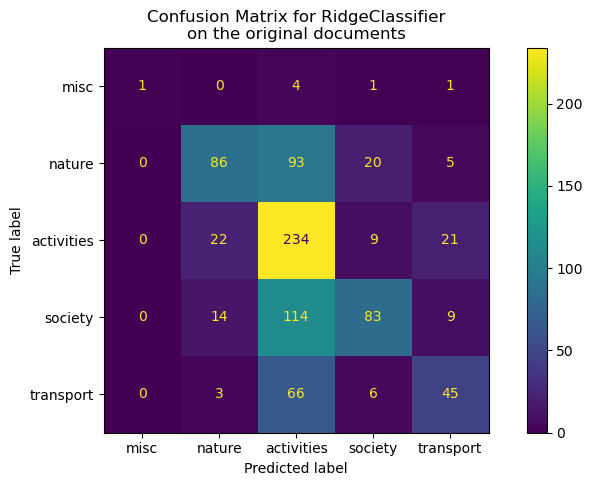

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
target_names = (['misc', 'nature', 'activities', 'society', 'transport'])
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(target_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [26]:
from sklearn.metrics import classification_report
classification_report(target_test, pred, output_dict=True)  

{'-1': {'precision': 1.0,
  'recall': 0.14285714285714285,
  'f1-score': 0.25,
  'support': 7.0},
 '0': {'precision': 0.688,
  'recall': 0.4215686274509804,
  'f1-score': 0.5227963525835866,
  'support': 204.0},
 '1': {'precision': 0.45792563600782776,
  'recall': 0.8181818181818182,
  'f1-score': 0.5872020075282308,
  'support': 286.0},
 '2': {'precision': 0.6974789915966386,
  'recall': 0.37727272727272726,
  'f1-score': 0.4896755162241888,
  'support': 220.0},
 '3': {'precision': 0.5555555555555556,
  'recall': 0.375,
  'f1-score': 0.44776119402985076,
  'support': 120.0},
 'accuracy': 0.5364396654719236,
 'macro avg': {'precision': 0.6797920366320044,
  'recall': 0.42697606315253367,
  'f1-score': 0.4594870140731714,
  'support': 837.0},
 'weighted avg': {'precision': 0.5954967463753476,
  'recall': 0.5364396654719236,
  'f1-score': 0.5230587657503337,
  'support': 837.0}}

In [27]:
tmp_dict = labelled_filtered_df[['Class', 'class_id']].groupby(by=['class_id', 'Class']).count().reset_index().to_dict(orient='records')
class_labels = {r['class_id']:r['Class'] for r in tmp_dict}

In [29]:
import shap
explainer = shap.Explainer(clf, X_train, feature_names=feature_names, output_names=['activities', 'nature', 'society', 'transport'])
explanation = explainer(X_train)

In [30]:
explanation.shape

(3346, 398, 5)

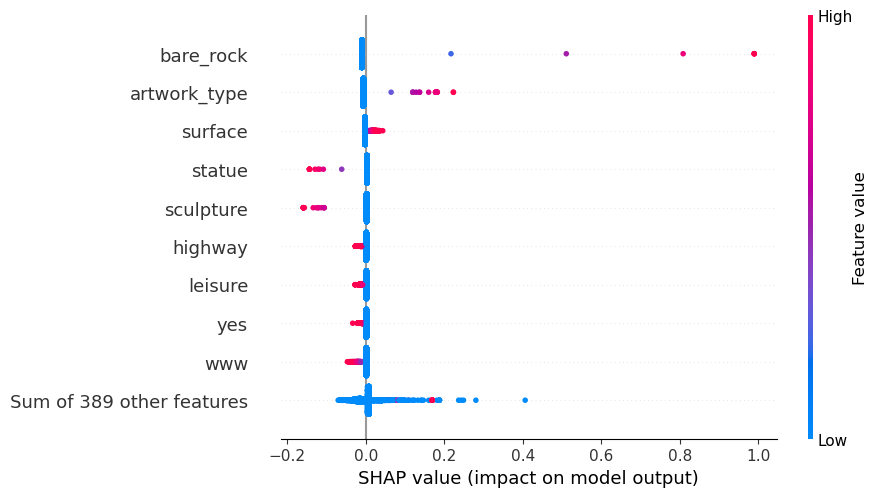

In [31]:
shap.plots.beeswarm(explanation[:, :, 0])

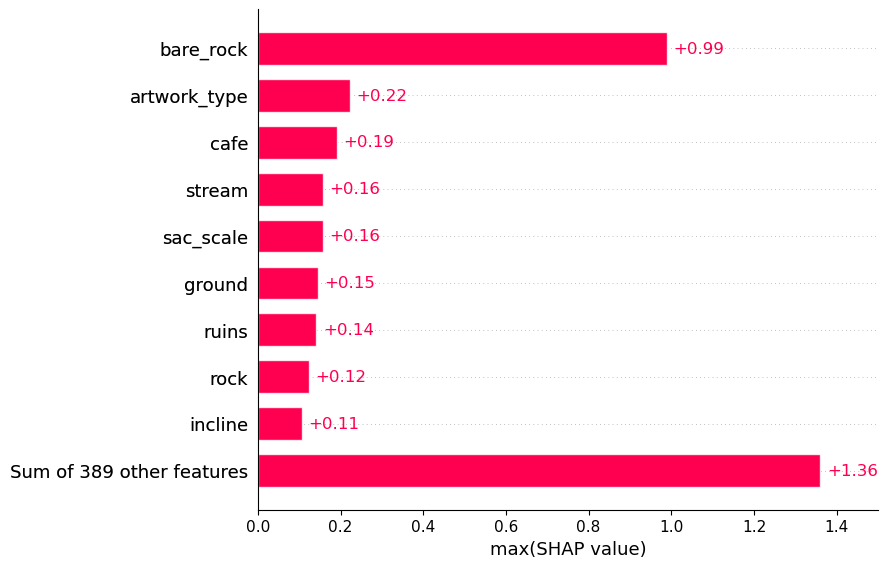

In [32]:
shap.plots.bar(explanation[:, :, 0].max(0))

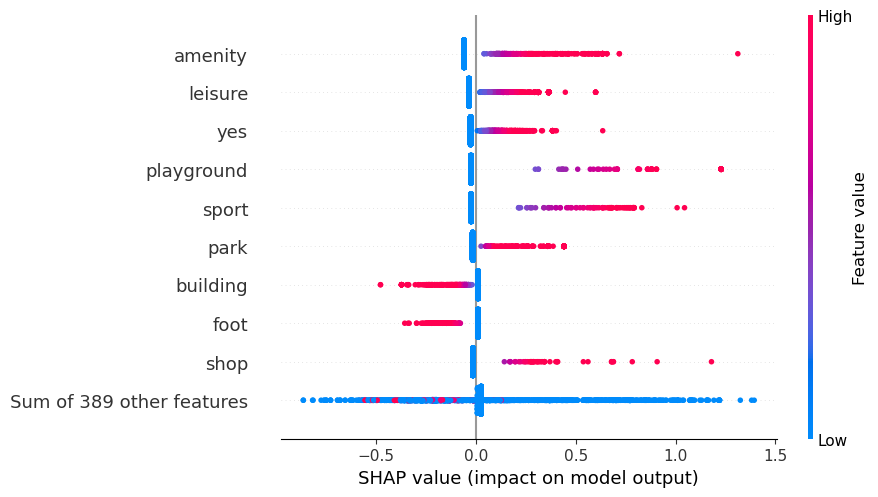

In [33]:
shap.plots.beeswarm(explanation[:, :, 1])

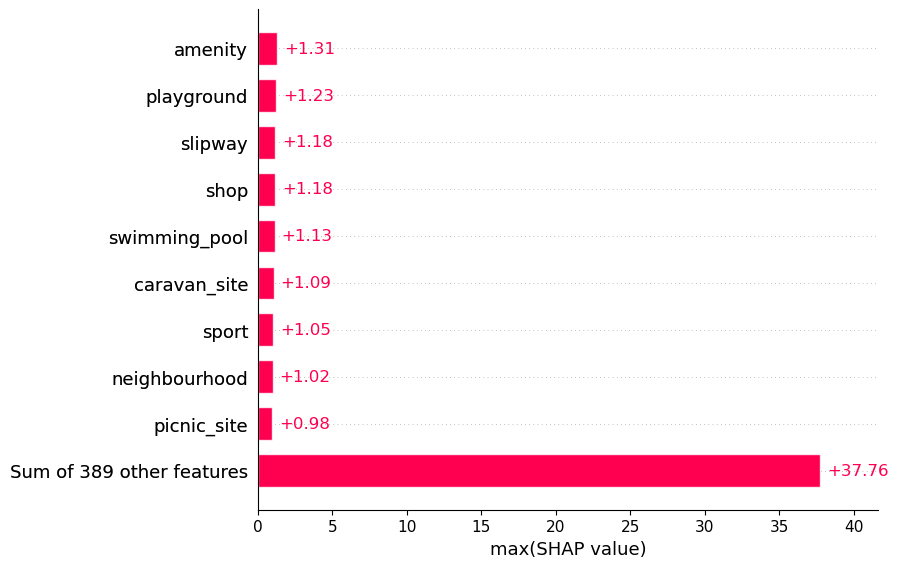

In [34]:
shap.plots.bar(explanation[:, :, 1].max(0))

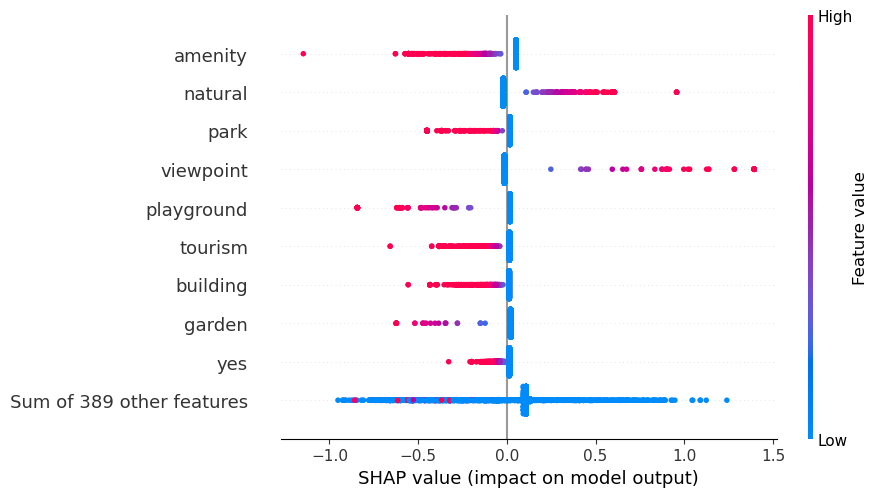

In [35]:
shap.plots.beeswarm(explanation[:, :, 2])

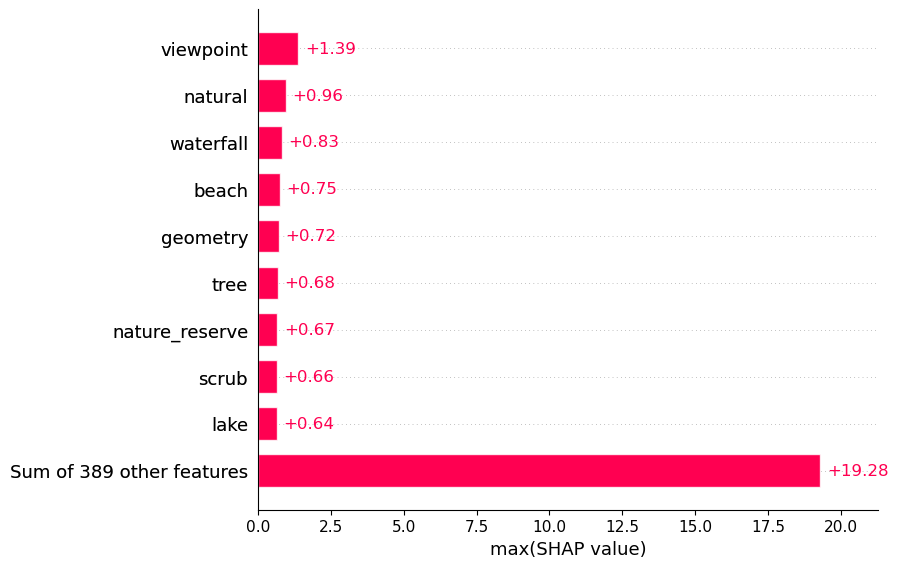

In [36]:
shap.plots.bar(explanation[:, :, 2].max(0))

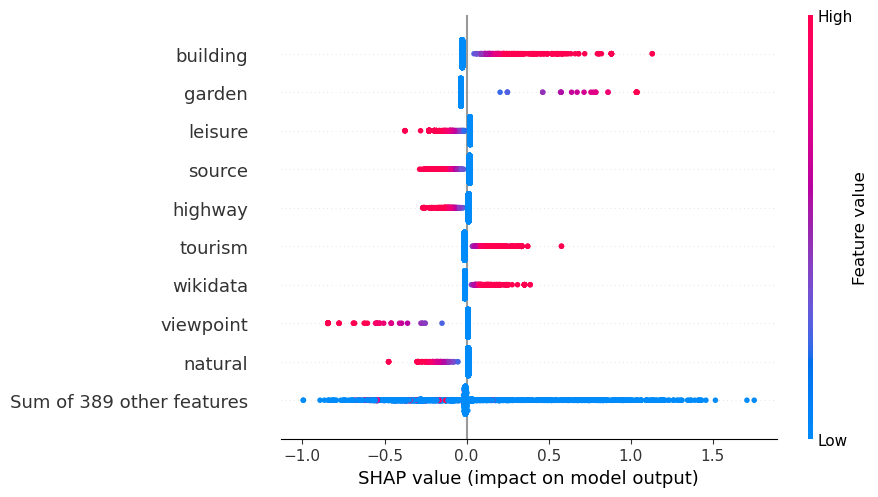

In [37]:
shap.plots.beeswarm(explanation[:, :, 3])

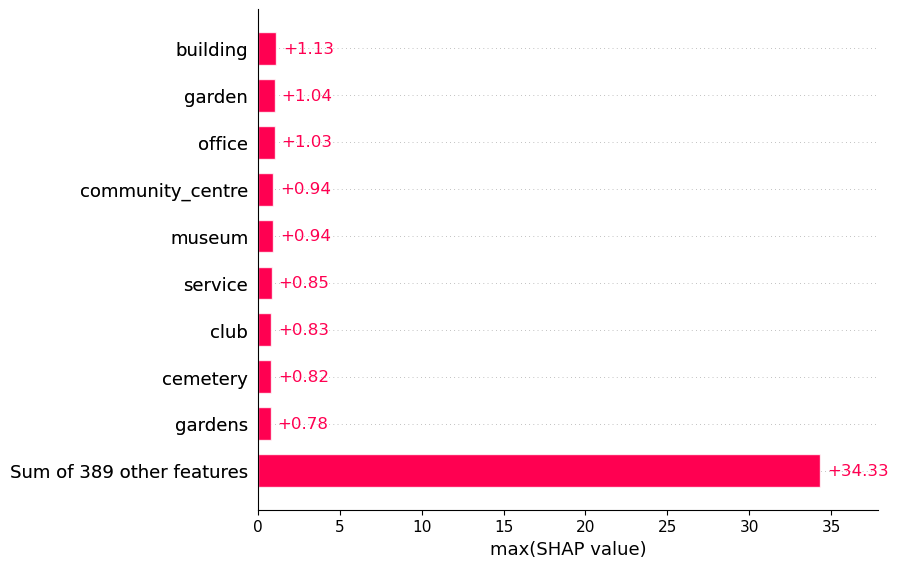

In [38]:
shap.plots.bar(explanation[:, :, 3].max(0))

In [39]:
prediction_errors = [a != pred[idx] for idx, a in enumerate(list(target_test))]

In [40]:
data_test[prediction_errors]

1775    artwork_type sculpture material steel tourism ...
1516                                       leisure garden
3995                                                     
2473    cycleway:left shared_lane cycleway:left:lane p...
2440                                                     
                              ...                        
3044    bicycle designated cycleway:surface asphalt fo...
4203                                       leisure garden
3894                                         club fishing
1042                                                     
721                                                      
Name: tags, Length: 388, dtype: object

In [41]:
error_preds = [p for idx, p in enumerate(pred) if prediction_errors[idx]]
error_actual = [p for idx, p in enumerate(list(target_test)) if prediction_errors[idx]]
error_df = pd.DataFrame({'index': data_test[prediction_errors].index, 'osm_info': list(data_test[prediction_errors]), 'pred': error_preds, 'actual': error_actual})
error_df

,index,osm_info,pred,actual
0,1775,artwork_type sculpture material steel tourism ...,2,3
1,1516,leisure garden,2,1
2,3995,,1,2
3,2473,cycleway:left shared_lane cycleway:left:lane p...,3,1
4,2440,,1,0
...,...,...,...,...
383,3044,bicycle designated cycleway:surface asphalt fo...,3,1
384,4203,leisure garden,2,0
385,3894,club fishing,2,0
386,1042,,1,3


In [42]:
error_df = pd.merge(error_df, detailed_df[['index', 'record_id', 'topic', 'Subclass']], how="left", on=["index", "index"])
error_df

,index,osm_info,pred,actual,record_id,topic,Subclass
0,1775,artwork_type sculpture material steel tourism ...,2,3,141,0,trail-path-and-canal
1,1516,leisure garden,2,1,118,33,flora and funa
2,3995,,1,2,353,73,"art, history and culture"
3,2473,cycleway:left shared_lane cycleway:left:lane p...,3,1,210,23,natural landmarks
4,2440,,1,0,206,28,sport complexes
...,...,...,...,...,...,...,...
383,3044,bicycle designated cycleway:surface asphalt fo...,3,1,263,66,natural landmarks
384,4203,leisure garden,2,0,371,15,picnic
385,3894,club fishing,2,0,344,16,picnic
386,1042,,1,3,77,0,trail-path-and-canal


In [43]:
error_df['lack_of_context'] = error_df.apply(lambda row: row['osm_info'].strip() in ('', '[]'), axis=1)
error_df

,index,osm_info,pred,actual,record_id,topic,Subclass,lack_of_context
0,1775,artwork_type sculpture material steel tourism ...,2,3,141,0,trail-path-and-canal,False
1,1516,leisure garden,2,1,118,33,flora and funa,False
2,3995,,1,2,353,73,"art, history and culture",True
3,2473,cycleway:left shared_lane cycleway:left:lane p...,3,1,210,23,natural landmarks,False
4,2440,,1,0,206,28,sport complexes,True
...,...,...,...,...,...,...,...,...
383,3044,bicycle designated cycleway:surface asphalt fo...,3,1,263,66,natural landmarks,False
384,4203,leisure garden,2,0,371,15,picnic,False
385,3894,club fishing,2,0,344,16,picnic,False
386,1042,,1,3,77,0,trail-path-and-canal,True


In [44]:
error_df.groupby('lack_of_context').count()

,index,osm_info,pred,actual,record_id,topic,Subclass
lack_of_context,,,,,,,
False,168,168,168,168,168,168,164
True,220,220,220,220,220,220,218


In [45]:
error_df.to_csv('outputs/error_poi_description.csv')

In [46]:
ALL = len(target_test)
ERRORS = len(error_df)
raw_precision = (ALL-ERRORS)/ALL*100
raw_precision

53.643966547192356

In [54]:
error_df[error_df['lack_of_context']]

,index,osm_info,pred,actual,record_id,topic,Subclass,lack_of_context
2,3995,,1,2,353,73,"art, history and culture",True
4,2440,,1,0,206,28,sport complexes,True
5,2344,,1,2,199,51,"art, history and culture",True
6,2587,,1,2,220,44,human made landmarks,True
8,3954,,1,0,348,41,sport complexes,True
...,...,...,...,...,...,...,...,...
379,1058,,1,2,80,44,human made landmarks,True
381,1550,,1,2,123,22,"art, history and culture",True
382,1257,,1,0,97,3,food and beverage,True
386,1042,,1,3,77,0,trail-path-and-canal,True


In [60]:
# if there is context - it can be derived from the context!
LACK_OF_CONTEXT = len(error_df[error_df['lack_of_context']])
with_context_error = (ALL-ERRORS)/(ALL-LACK_OF_CONTEXT)*100  
with_context_error

72.77147487844408

**conclusion**: these feautres are relatively standardize due to their known imporatnace otherwise much lower results expected from the OSM attribute information

In [61]:
# key classification
# use presence of keys to predict class

In [62]:
def get_all_key_values_tags(poi_id):
    if poi_id not in osm_detailed_information.keys():
        logger.info(f'missing key in OSM details: {poi_id}')
        return []
    all_info = osm_detailed_information[poi_id]
    tags = []
    for oid, values in all_info.items():
        if 'elements' in values.keys():
            tmp_tags = [[k for k,v in elem['tags'].items() if 'name' not in k] for elem in values['elements'] if 'tags' in elem]
            tmp_tags = [t for tag in tmp_tags for t in tag]
            tags.extend(tmp_tags)
    return tags

get_all_key_values_tags('5')

['boundary',
 'iucn_level',
 'leisure',
 'operator',
 'protect_class',
 'protection_title',
 'ref:capad:pa_id',
 'ref:vicmap:prims_id',
 'source',
 'start_date',
 'type']

In [63]:
filtered_df = detailed_df[['index', 'record_id', 'topic', 'Class ID', 'Class', 'Subclass']]
filtered_df['tags'] = filtered_df.apply(lambda row: get_all_key_values_tags(str(row['index'])), axis=1)
filtered_df.head()

2024-12-14 19:36:49.129 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 20
2024-12-14 19:36:49.162 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3551
2024-12-14 19:36:49.164 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3552
2024-12-14 19:36:49.164 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3553
2024-12-14 19:36:49.165 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3554
2024-12-14 19:36:49.165 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3555


,index,record_id,topic,Class ID,Class,Subclass,tags
0,0,1,2,0.0,nature,natural landmarks,"[addr:housenumber, addr:postcode, addr:street,..."
1,1,1,2,0.0,nature,natural landmarks,"[natural, surface]"
2,2,1,1,0.0,nature,flora and funa,[]
3,3,1,2,0.0,nature,natural landmarks,[]
4,4,1,23,0.0,nature,natural landmarks,[waterway]


In [64]:
all_keys = [k for keys in filtered_df['tags'] for k in keys]
logger.info(f'all keys: {len(all_keys)} - unqiue keys: {len(set(all_keys))}')

2024-12-14 19:36:50.131 | INFO     | __main__:<module>:2 - all keys: 12701 - unqiue keys: 472


In [65]:
from collections import Counter

features = [k for k,v in Counter(all_keys).items() if v > 25]

In [66]:
class_dicts = filtered_df[['Class', 'tags']].to_dict(orient='records')
classification_records = []
for class_dict in class_dicts:
    if class_dict['Class'] == 'unknown':
        continue
    classification_record = {'class': class_dict['Class']}
    for feature in features:
        if feature in class_dict['tags']:
           classification_record[feature] = 1
        else:
            classification_record[feature] = 0
    classification_records.append(classification_record)

classfication_df = pd.DataFrame(classification_records)
classfication_df.head()

,class,addr:housenumber,addr:postcode,addr:street,natural,surface,waterway,leisure,operator,source,...,area,horse,cycleway:both,maxspeed,shop,railway,train,water,lanes,crossing
0,nature,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nature,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,nature,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,nature,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,nature,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
from sklearn.ensemble import GradientBoostingClassifier

y = classfication_df['class'].astype('category').cat.codes
X = classfication_df.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=432)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=432)

cv_results = cross_validate(clf, X_train, y_train, cv=10, return_estimator=True)
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

pred = clf.predict(X_test)

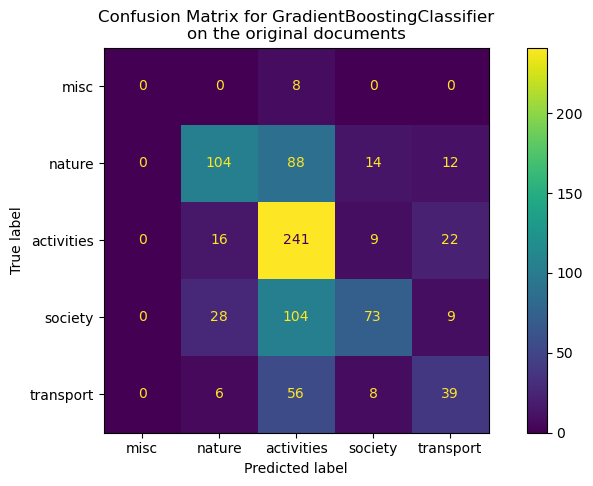

In [72]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [73]:
from sklearn.metrics import classification_report
classification_report(y_test, pred, output_dict=True)  

{'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0},
 '0': {'precision': 0.6753246753246753,
  'recall': 0.47706422018348627,
  'f1-score': 0.5591397849462365,
  'support': 218.0},
 '1': {'precision': 0.48490945674044267,
  'recall': 0.8368055555555556,
  'f1-score': 0.6140127388535032,
  'support': 288.0},
 '2': {'precision': 0.7019230769230769,
  'recall': 0.3411214953271028,
  'f1-score': 0.4591194968553459,
  'support': 214.0},
 '3': {'precision': 0.47560975609756095,
  'recall': 0.3577981651376147,
  'f1-score': 0.4083769633507853,
  'support': 109.0},
 'accuracy': 0.5459976105137395,
 'macro avg': {'precision': 0.4675533930171511,
  'recall': 0.4025578872407518,
  'f1-score': 0.4081297968011742,
  'support': 837.0},
 'weighted avg': {'precision': 0.5841430162941449,
  'recall': 0.5459976105137395,
  'f1-score': 0.5274704937160909,
  'support': 837.0}}

In [74]:
feature_importance = clf.feature_importances_
importance_df = pd.DataFrame({'features': X_train.columns,
                              'importance': feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
list(importance_df.features)[:10]

['leisure',
 'layer',
 'natural',
 'description',
 'highway',
 'addr:city',
 'tourism',
 'building',
 'amenity',
 'operator:type']

## 4. Matched Features

Based on geometries, we have where people put a point to represent a feature, we have their matched osm geometry (not-necessarily a point) and we have the path. The aim of this part is to find out:

* How accurate is the point-based representation?
* How many POIs are directly accessible to route (ready to be explored and visited) vs. how many are POIs in vita, and we can observe them in the far.

In [75]:
import pyproj
from shapely.geometry import Point, LineString
from shapely.ops import transform

# wgs84_pt = Point(test_case['lng'], test_case['lat'])
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32755')

In [76]:
# 1. path geometries - POI is the key of the dataframe (repeating the path geometry for the POIs it has)
# 2. POI point-based representation
with open('dataset/walkingmaps.json', encoding="utf8") as fp:
    wm_dataset = json.load(fp)

path_dicts = []
poi_dicts = []

poi_id = 0
for data_records in wm_dataset:
    path_details_points = [Point(p['lng'], p['lat']) for p in data_records['pathDetails']]
    path = LineString(path_details_points)
    for poi in data_records['pois']:
        path_dicts.append({'poi_id': poi_id, 'geometry': path})
        poi_point = Point(poi['lng'], poi['lat'])
        poi_dicts.append({'poi_id': poi_id, 'geometry': poi_point})
        poi_id += 1

In [77]:
import geopandas as gpd

all_paths = gpd.GeoDataFrame(path_dicts)
all_markers = gpd.GeoDataFrame(poi_dicts)

In [78]:
import overpass
import geojson
api = overpass.API(timeout=500)

def get_geometries_from_OSM(osm_key):
    splits = osm_key.split(':')
    osm_type = splits[0]
    osm_id = splits[1]
    query = f"{osm_type}({osm_id});out geom;"
    result = api.get(query)
    test_gdf = gpd.read_file(geojson.dumps(result), driver='GeoJSON')
    if 'name' not in test_gdf.columns:
        test_gdf['name'] = None
    return test_gdf[~test_gdf.geometry.is_empty][['name', 'geometry']]

In [79]:
get_geometries_from_OSM('way:1089591567')

,name,geometry
1,Fairhaven Surf Life Saving Club,"LINESTRING (144.08436 -38.46843, 144.08435 -38..."


In [80]:
from tqdm import tqdm
import os

# 3. POI matched geometries from OSM? if it is multiple? POI id is not the unique key anymore
if os.path.isfile("outputs/dataframes/osm_geometries.geojson"):
	all_osms_projected = gpd.read_file("outputs/dataframes/osm_geometries.geojson", driver="GeoJSON")

else:
    all_matched_osms = {k:v for k,v in osm_detailed_information.items() if k in poi_matched_and_founds}
    all_gdfs = []
    for poi_id, matches in tqdm(all_matched_osms.items()):
        for osm_key in matches.keys():
            try:
                if len(combined_gdf[combined_gdf['osm_key'] == osm_key]) == 0:
                    tmp_gdf = get_geometries_from_OSM(osm_key)
                else:
                    tmp_gdf = combined_gdf[combined_gdf['osm_key'] == osm_key]
                tmp_gdf['osm_key'] = osm_key
                tmp_gdf['poi_id'] = poi_id
                all_gdfs.append(tmp_gdf)
            except Exception as e:
                logger.warning(f'error in {poi_id} - {osm_key}', e)

    tmp_combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))
    errors = ['way:17339082', 'node:232890230', 'node:202031608', 'node:178265674', 'node:1000788635']  # TODO - find the reason for annotation errors / fix relation issue!
    all_osms = tmp_combined_gdf[~tmp_combined_gdf['osm_key'].isin(errors)]
    print(all_osms.head())

    all_osms.set_crs(wgs84, inplace=True)
    
    # project to UTM
    all_osms_projected = all_osms.to_crs(utm)

    all_osms_projected.drop_duplicates(inplace=True)
    all_osms_projected.to_file("outputs/dataframes/osm_geometries.geojson", driver="GeoJSON")

In [81]:
all_paths.set_crs(wgs84, inplace=True)
all_markers.set_crs(wgs84, inplace=True)


# project to UTM
all_paths_projected = all_paths.to_crs(utm)
all_markers_projected = all_markers.to_crs(utm)

In [82]:
all_paths_projected['poi_id'] = all_paths_projected['poi_id'].astype(str)
all_markers_projected['poi_id'] = all_markers_projected['poi_id'].astype(str)

In [83]:
osm_paths = all_osms_projected.merge(all_paths_projected, how='left', on='poi_id', suffixes=('_osm', '_path'))
osm_markers = all_osms_projected.merge(all_markers_projected, how='left', on='poi_id', suffixes=('_osm', '_marker'))
marker_paths = all_markers_projected.merge(all_paths_projected, how='left', on='poi_id', suffixes=('_marker', '_path'))

### 4.1 Distance of OSM from path

In [84]:
osm_paths['distance'] = osm_paths.apply(lambda row: row['geometry_osm'].distance(row['geometry_path']), axis=1)
osm_paths

,name,osm_key,poi_id,geometry_osm,geometry_path,distance
0,Fairhaven Surf Life Saving Club,way:1089591567,0,"LINESTRING (245626.149 5738181.179, 245624.792...","LINESTRING (245632.041 5738144.822, 246231.151...",36.831181
1,Fairhaven,way:1007494584,1,"LINESTRING (244099.747 5738111.339, 244107.629...","LINESTRING (245632.041 5738144.822, 246231.151...",0.000000
2,Painkalac Creek,way:30501933,4,"LINESTRING (244152.558 5741085.677, 244177.172...","LINESTRING (245632.041 5738144.822, 246231.151...",44.758793
3,None,way:69366108,6,"LINESTRING (246848.218 5738495.009, 246867.434...","LINESTRING (245632.041 5738144.822, 246231.151...",11.903296
4,Aireys Inlet Skate Park,way:69366081,6,"LINESTRING (246840.690 5738478.884, 246862.489...","LINESTRING (245632.041 5738144.822, 246231.151...",13.497913
...,...,...,...,...,...,...
3163,None,way:1154250924,4389,"LINESTRING (328545.697 5830837.069, 328546.364...","LINESTRING (328546.960 5830470.685, 328535.139...",6.933603
3164,None,way:1110152163,4390,"LINESTRING (328745.728 5830711.777, 328743.814...","LINESTRING (328546.960 5830470.685, 328535.139...",26.456681
3165,None,way:1110152159,4390,"LINESTRING (328718.055 5830692.776, 328716.555...","LINESTRING (328546.960 5830470.685, 328535.139...",28.659478
3166,None,way:1110152160,4390,"LINESTRING (328750.001 5830684.446, 328748.110...","LINESTRING (328546.960 5830470.685, 328535.139...",36.230207


<Axes: xlabel='distance', ylabel='Count'>

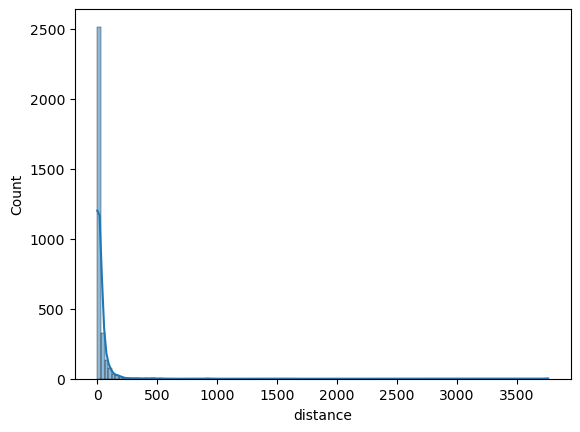

In [85]:
sns.histplot(data=osm_paths, x="distance", binwidth=30, kde=True)

<Axes: xlabel='distance', ylabel='Count'>

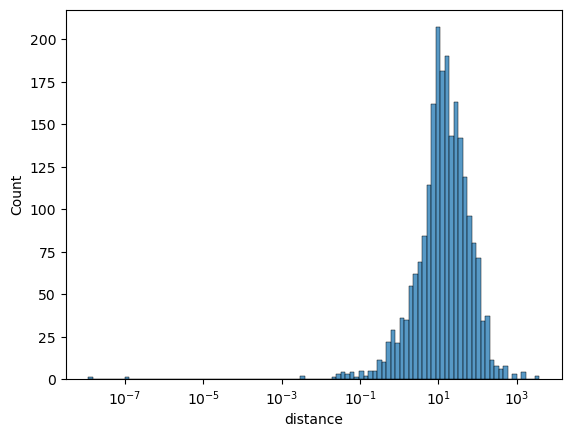

In [86]:
sns.histplot(data=osm_paths, x="distance", log_scale=True)

In [87]:
osm_paths[osm_paths['distance'] > 300].sort_values('distance')

,name,osm_key,poi_id,geometry_osm,geometry_path,distance
985,Hanson Bay,way:367790802,1269,"LINESTRING (-415748.433 5966119.760, -415750.5...","LINESTRING (-427139.549 5972355.321, -427138.3...",308.572642
586,Byron Bay,node:3020491481,756,POINT (1147913.423 6814063.553),"LINESTRING (1146240.900 6814302.557, 1146270.9...",315.366750
286,Dolphin Bay Drive,way:61376690,325,"LINESTRING (1110183.689 7065570.930, 1110182.7...","LINESTRING (1109087.416 7067640.151, 1109087.9...",323.762437
251,Tidal Overlook,node:257499290,281,POINT (440800.969 5680215.346),"LINESTRING (441175.271 5679757.431, 441135.734...",331.319109
747,Argus Centre,way:28775678,954,"LINESTRING (320430.257 5813307.494, 320465.101...","LINESTRING (320314.826 5813683.508, 320357.588...",332.468160
2926,Wombat Reservoir,way:32619282,3951,"LINESTRING (249922.753 5858041.889, 249821.393...","LINESTRING (249726.474 5858311.456, 249680.418...",333.453749
748,Welsh Church,way:28775707,955,"LINESTRING (320396.706 5813274.899, 320415.061...","LINESTRING (320314.826 5813683.508, 320357.588...",351.824195
2295,Royal Melbourne Yacht Squadron,way:1006723861,3034,"LINESTRING (321085.400 5807359.605, 321070.030...","LINESTRING (316739.732 5809921.043, 316871.590...",388.204791
1438,Community Lane,way:23274625,1888,"LINESTRING (454536.975 5777537.511, 454522.953...","LINESTRING (454137.459 5777611.218, 454139.228...",394.021322
1437,Community Lane,way:674386038,1888,"LINESTRING (454513.272 5777420.317, 454517.170...","LINESTRING (454137.459 5777611.218, 454139.228...",415.884649


### 4.2 Distance of marker from OSM matches

In [88]:
osm_markers['distance'] = osm_markers.apply(lambda row: row['geometry_osm'].distance(row['geometry_marker']), axis=1)
osm_markers

,name,osm_key,poi_id,geometry_osm,geometry_marker,distance
0,Fairhaven Surf Life Saving Club,way:1089591567,0,"LINESTRING (245626.149 5738181.179, 245624.792...",POINT (245636.186 5738145.172),37.379334
1,Fairhaven,way:1007494584,1,"LINESTRING (244099.747 5738111.339, 244107.629...",POINT (246092.200 5738183.760),18.282913
2,Painkalac Creek,way:30501933,4,"LINESTRING (244152.558 5741085.677, 244177.172...",POINT (246756.480 5738221.628),78.971736
3,None,way:69366108,6,"LINESTRING (246848.218 5738495.009, 246867.434...",POINT (246876.183 5738468.803),15.271587
4,Aireys Inlet Skate Park,way:69366081,6,"LINESTRING (246840.690 5738478.884, 246862.489...",POINT (246876.183 5738468.803),13.695416
...,...,...,...,...,...,...
3163,None,way:1154250924,4389,"LINESTRING (328545.697 5830837.069, 328546.364...",POINT (328549.043 5830993.562),7.764502
3164,None,way:1110152163,4390,"LINESTRING (328745.728 5830711.777, 328743.814...",POINT (328807.083 5830689.442),40.939589
3165,None,way:1110152159,4390,"LINESTRING (328718.055 5830692.776, 328716.555...",POINT (328807.083 5830689.442),60.420844
3166,None,way:1110152160,4390,"LINESTRING (328750.001 5830684.446, 328748.110...",POINT (328807.083 5830689.442),37.456327


<Axes: xlabel='distance', ylabel='Count'>

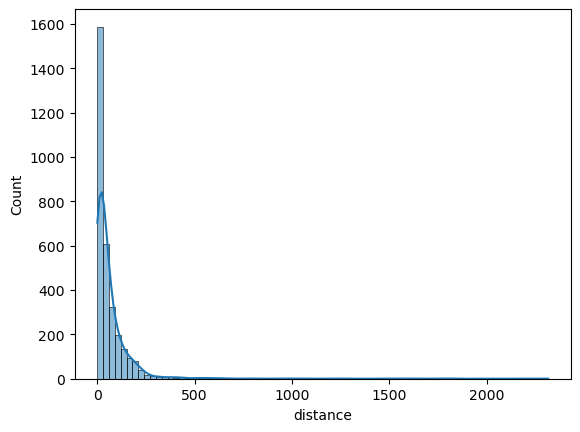

In [89]:
sns.histplot(data=osm_markers, x="distance", binwidth=30, kde=True)

<Axes: xlabel='distance', ylabel='Count'>

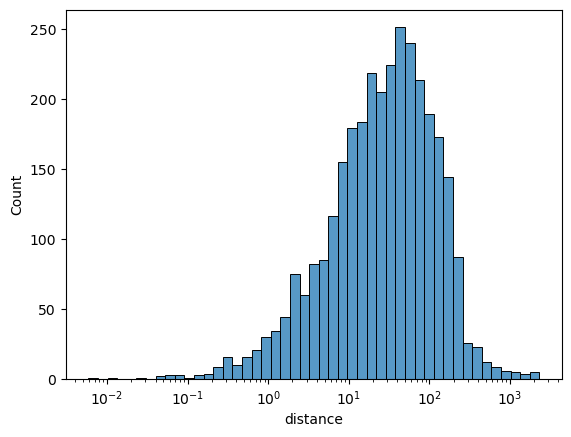

In [90]:
sns.histplot(data=osm_markers, x="distance", log_scale=True)

In [91]:
osm_markers[osm_markers['distance'] > 1000].sort_values('distance')  # could be an issue of polygon vs. polyline?

,name,osm_key,poi_id,geometry_osm,geometry_marker,distance
2713,Centenary Track,way:150175841,3591,"LINESTRING (266172.710 5829832.259, 266183.486...",POINT (267195.435 5828693.220),1016.579661
251,Tidal Overlook,node:257499290,281,POINT (440800.969 5680215.346),POINT (440170.708 5679371.519),1053.219660
2965,Little Waterloo Bay,node:2705395612,4019,POINT (451231.548 5674617.222),POINT (450682.797 5675572.979),1102.088478
1547,Barwon Rowing Club,way:266715496,2044,"LINESTRING (268159.913 5772667.075, 268153.678...",POINT (266939.477 5772716.281),1197.085726
2964,Little Waterloo Bay,node:2705395612,4018,POINT (451231.548 5674617.222),POINT (450798.403 5675788.174),1248.496951
649,Lake track,way:19791804,840,"LINESTRING (350473.634 5798386.526, 350445.106...",POINT (351058.258 5796951.758),1275.716561
2378,Kyneton,node:258071034,3131,POINT (273928.866 5873415.614),POINT (273727.441 5874873.408),1471.643301
517,Station Pier Swinging Basin,node:9262216550,674,POINT (317703.832 5808967.737),POINT (319205.253 5809280.609),1533.673093
2962,Oberon Bay,node:2707956424,4011,POINT (441688.499 5675618.975),POINT (443195.143 5675167.479),1572.840086
1522,None,way:563484086,2012,"LINESTRING (298830.378 5838848.497, 298821.785...",POINT (297308.071 5839687.767),1733.935921


In [92]:
detailed_df[detailed_df['index'].isin([int(poi_id) for poi_id in osm_markers[osm_markers['distance'] > 1000].sort_values('distance').poi_id])]  # mainly natural features!

,index,record_id,record_title,record_description,poi_title,poi_summary,latitude,longitude,geometry,Unnamed: 0,...,document,is_found,class,Class,Class ID,Count,Name,Representation,Representative_Docs,Subclass
281,281,19,Tidal River to Squeaky Beach return created by...,"This is a great walk. As its name suggests, Sq...",Tidal Overlook,It is worth the short deviation off the track ...,-39.032663,146.308750,POINT (146.30875 -39.03266),3999,...,Tidal Overlook: It is worth the deviation off ...,True,natural peak,activities,1.0,24,39_pier_prince_kiosk_cunn,"['pier', 'prince', 'kiosk', 'cunn', 'highrise'...","[""St Kilda Pier: home of the famou Kirby' Kios...",fishing to surfing
325,325,22,Noosa Heads Coastal Track created by Ambler,This walk follows the shoreline from the main ...,Dolphin Bay,Looking towards Picnic Cove.,-26.377527,153.107973,POINT (153.10797 -26.37753),31,...,Dolphin Bay: Looking to Picnic Cove.,True,highway residential,nature,0.0,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,natural landmarks
510,510,33,Anderson to Kilcunda created by Embers,This walk goes from Anderson and ends at Kilcu...,Bass Coast Rail Trail,Bass Coast Rail Trail,-38.534739,145.461216,POINT (145.46122 -38.53474),3701,...,Rail Trail: Rail Trail,True,highway cycleway,nature,0.0,12,66_oscar_trail_blind_spring,"['oscar', 'trail', 'blind', 'spring', 'creek',...",['Oscar Walk: Oscar Walk beside the Bank start...,natural landmarks
674,674,46,Delights of Albert Park created by dianek,1. Start at the corner of Bridport and Montagu...,Station Pier,"Cross Beaconsfield Pde, head onto the beach, t...",-37.846011,144.945171,POINT (144.94517 -37.84601),4001,...,"Station Pier: Cros s Pde, head onto the beach,...",False,NaN,activities,1.0,24,39_pier_prince_kiosk_cunn,"['pier', 'prince', 'kiosk', 'cunn', 'highrise'...","[""St Kilda Pier: home of the famou Kirby' Kios...",fishing to surfing
840,840,60,Lysterfield homesteads & farms created by Ray ...,"For those accustomed to the lake shore, there ...",Lake track,This section of track adjoins a flora & fauna ...,-37.962843,145.304489,POINT (145.30449 -37.96284),4220,...,Lake track: Thi section of track adjoin a flor...,True,highway track,activities,1.0,15,58_golf_tractor_course_emmett,"['golf', 'tractor', 'course', 'emmett', 'spine...","[""Golf Club: Walk along the south perimeter of...",sport complexes
2012,2012,165,Sunbury Blind Creek: Killara Heights to Rupert...,Starting at Phillip Drive it is a downhill rid...,Sunbury BMX and Skate Park,Just a little detour from the path is the Sunb...,-37.567557,144.704937,POINT (144.70494 -37.56756),491,...,BMX and Skate Park: Just a little detmy from t...,False,NaN,activities,1.0,33,28_skate_bmx_incrbly_bigger,"['skate', 'bmx', 'incrbly', 'bigger', 'mcg', '...",['Skate Park: There is a skate park here that ...,sport complexes
2044,2044,169,Barwon River Walk: Troop Trail created by Heal...,The Troop Loop is a walking/running circuit ar...,Rowing,Walk past the rowing sheds. Lots of action of ...,-38.163349,144.339787,POINT (144.33979 -38.16335),2352,...,Rowing: Walk past the rowing sheds. Lot of act...,True,leisure sports_centre,activities,1.0,11,71_rowing_rower_blackbirds_regattum,"['rowing', 'rower', 'blackbirds', 'regattum', ...",['Rowing: Walk past the rowing sheds. Lot of a...,fishing to surfing
2183,2183,183,Black Rock Beach to Ricketts Point Marine Sanc...,Start at Black Rock Gardens which is overlooke...,Swans and pelicans,There are often swans and pelicans at this spo...,-37.981737,145.018185,POINT (145.01818 -37.98174),273,...,s and pelicans: There are often s and pelican ...,False,NaN,nature,0.0,153,1_bird_duck_birdlife_ducks,"['bird', 'duck', 'birdlife', 'ducks', 'feng', ...",['Black s: Keep an eye out for the birdlife at...,flora and funa
2895,2895,248,"Gilberts Gully Trail, Marysville created by Ha...",This walk takes you through a dry mixed-specie...,Mt Gordon,This trail begins 

### 4.3 Distance of marker from path

In [93]:
marker_paths['distance'] = marker_paths.apply(lambda row: row['geometry_marker'].distance(row['geometry_path']), axis=1)
marker_paths

,poi_id,geometry_marker,geometry_path,distance
0,0,POINT (245636.186 5738145.172),"LINESTRING (245632.041 5738144.822, 246231.151...",0.000502
1,1,POINT (246092.200 5738183.760),"LINESTRING (245632.041 5738144.822, 246231.151...",0.003862
2,2,POINT (246329.815 5738200.421),"LINESTRING (245632.041 5738144.822, 246231.151...",0.003482
3,3,POINT (246582.569 5738212.986),"LINESTRING (245632.041 5738144.822, 246231.151...",0.004637
4,4,POINT (246756.480 5738221.628),"LINESTRING (245632.041 5738144.822, 246231.151...",0.001621
...,...,...,...,...
4387,4387,POINT (328410.136 5830674.908),"LINESTRING (328546.960 5830470.685, 328535.139...",0.087915
4388,4388,POINT (328671.456 5831192.229),"LINESTRING (328546.960 5830470.685, 328535.139...",0.000430
4389,4389,POINT (328549.043 5830993.562),"LINESTRING (328546.960 5830470.685, 328535.139...",0.058850
4390,4390,POINT (328807.083 5830689.442),"LINESTRING (328546.960 5830470.685, 328535.139...",0.012724


<Axes: xlabel='distance', ylabel='Count'>

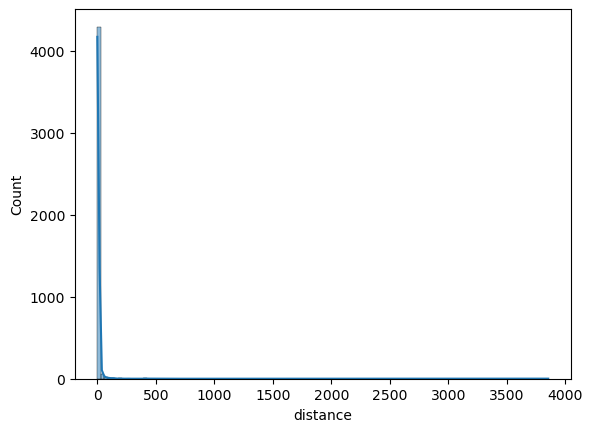

In [94]:
sns.histplot(data=marker_paths, x="distance", binwidth=30, kde=True)

In [95]:
marker_paths[marker_paths['distance'] > 300].sort_values('distance')  # could be an issue of polygon vs. polyline?

,poi_id,geometry_marker,geometry_path,distance
3951,3951,POINT (249866.085 5858031.586),"LINESTRING (249726.474 5858311.456, 249680.418...",312.759216
955,955,POINT (320429.093 5813224.583),"LINESTRING (320314.826 5813683.508, 320357.588...",410.253319
954,954,POINT (320547.162 5813273.059),"LINESTRING (320314.826 5813683.508, 320357.588...",413.772280
956,956,POINT (320332.083 5813185.601),"LINESTRING (320314.826 5813683.508, 320357.588...",420.368948
1180,1180,POINT (439802.838 5776010.911),"LINESTRING (435762.728 5774293.298, 435851.985...",440.146798
1269,1269,POINT (-415429.738 5966302.530),"LINESTRING (-427139.549 5972355.321, -427138.3...",470.602660
3261,3261,POINT (342128.209 5800029.990),"LINESTRING (344101.899 5799812.314, 344022.195...",1356.506430
1266,1266,POINT (-428695.398 5960108.107),"LINESTRING (-427139.549 5972355.321, -427138.3...",3852.527216


In [96]:
detailed_df[detailed_df['index'].isin([int(poi_id) for poi_id in marker_paths[marker_paths['distance'] > 300].poi_id])]

,index,record_id,record_title,record_description,poi_title,poi_summary,latitude,longitude,geometry,Unnamed: 0,...,document,is_found,class,Class,Class ID,Count,Name,Representation,Representative_Docs,Subclass
954,954,69,Queen Victoria Market Heritage Trail created b...,"The Queen Victoria Market, established in 1878...",The Argus - corner Elizabeth and LaTrobe Street,The building housed the Argus newspaper for 30...,-37.810314,144.961404,POINT (144.96140 -37.81031),664,...,The Argu - corner and LaT Street: The building...,False,NaN,society,2.0,85,8_cottage_building_residence_terrace,"['cottage', 'building', 'residence', 'terrace'...","[""Bowring' Store, corner Avenue and th Street ...","art, history and culture"
955,955,69,Queen Victoria Market Heritage Trail created b...,"The Queen Victoria Market, established in 1878...",The Welsh Church - 320 LaTrobe Street,The first free dispensary for women in 1896 wa...,-37.810728,144.960051,POINT (144.96005 -37.81073),3683,...,The Welsh Church - LaT Street: The first free ...,False,NaN,society,2.0,20,47_women_hospital_rance_wctu,"['women', 'hospital', 'rance', 'wctu', 'christ...",['WCTU drinking : The wa erected in by the Wom...,human made landmarks
956,956,69,Queen Victoria Market Heritage Trail created b...,"The Queen Victoria Market, established in 1878...",Republic Tower - corner Queen and LaTrobe Street,Public art where you would normally expect a b...,-37.811060,144.958940,POINT (144.95894 -37.81106),1200,...,Republic Tower - corner Queen and LaT Street: ...,False,NaN,society,2.0,65,11_theatre_art_exhibition_gallery,"['theatre', 'art', 'exhibition', 'gallery', 'c...","['Museum: The museum ha eight galleries, inclu...",human made landmarks
1180,1180,89,Moe - Yallourn Rail Trail created by Park Tracks,Following the route of the old rail branch lin...,Lake Narraccan Jetty,The detour at Sullivans Road to Lake Narraccan...,-38.161789,146.312854,POINT (146.31285 -38.16179),526,...,Lake Jetty: The detmy at Sullivan Road to Lake...,False,NaN,activities,1.0,27,35_fishing_trout_fish_try,"['fishing', 'trout', 'fish', 'try', 'platform'...",['Les Stone Park Wetlands: A great spot to try...,fishing to surfing
1266,1266,98,"Kangaroo Island Wilderness Trail, South Austra...",This multi-day walk which only opened on 1 Oct...,Cape Du Couedic,Location of the lightstation and Admirals Arch...,-36.058814,136.705112,POINT (136.70511 -36.05881),4138,...,Cape Du Couc: Location of the station and Admi...,True,highway secondary,transport,3.0,17,53_station_railway_du_travelled,"['station', 'railway', 'du', 'travelled', 'cou...","['Maryugh Railway Station, Station Street : Ma...",lines and stations
1269,1269,98,"Kangaroo Island Wilderness Trail, South Austra...",This multi-day walk which only opened on 1 Oct...,Hanson Bay,A killer seascape.,-36.016338,136.857204,POINT (136.85720 -36.01634),66,...,Bay: A killer seascape.,True,natural beach,nature,0.0,148,2_beach_bay_sand_tide,"['beach', 'bay', 'sand', 'tide', 'coastal', 'c...",['Apollo Bay beach: The beach is most sheltere...,natural landmarks
3261,3261,283,Kilcatten Park Rowville Vic 3178 created by Ra...,"Rowville today is densely settled, but this wa...",VFL Park,This arena was to be the home of Australian Ru...,-37.933604,145.203552,POINT (145.20355 -37.93360),3636,...,VFL Park: Thi arena wa to be the home of ian R...,False,NaN,activities,1.0,16,57_bowl_bowling_club_bocce,"['bowl', 'bowling', 'club', 'bocce', 'cricket'...",['Etihad Stadium: A multi-purpose venue which ...,sport complexes
3951,3951,348,Wombat Creek created by Ray Peace,"This is a relatively easy, but little known, w...",Wombat Creek reservoir,This reservoir is the water supply for Daylesf...,-37.390754,144.174528,POINT (144.17453 -37.39075),3251,...,Creek : Thi is the water supply for . The picn...,False,NaN,activities,1.0,46,18_seat_seating_rest_seats,"['seat', 'seating', 'rest', 'seats', 'bench', ...","[""Instion chairs: Take a seat and be inspired,...",picnic


## 5. POIs Selected vs. Nearby

In [97]:
# nearby POIs: get all, get_osm_pois_nearby([pois of a  walk]) then pick unique ones
# get information on a POI of a walk get_all_key_values(poi)
# walk and pois

In [98]:
walk_pois = detailed_df[['record_id', 'index']]
walk_pois.columns = ['walk_id', 'poi_id']
walk_pois

,walk_id,poi_id
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
...,...,...
4387,386,4387
4388,386,4388
4389,386,4389
4390,386,4390


In [99]:
def get_walk_pois_description(walk_id):
    pois = [str(p) for p in list(walk_pois[walk_pois['walk_id'] == walk_id]['poi_id'])]
    return {p:get_all_key_values(p) for p in pois}

ignore_cols = ['element_type', 'osmid', 'geometry', 'nodes', 'ways', 'fixme']

all_poi_matched = []
for p in list(walk_pois['poi_id']):
    if str(p) in annotations.keys():
        all_poi_matched.extend(annotations[str(p)])

def get_walk_nearby_pois_description(walk_id):
    pois = [str(p) for p in list(walk_pois[walk_pois['walk_id'] == walk_id]['poi_id'])]

    raw_nearby_pois = get_osm_pois_nearby(pois)
    all_results = {}
    for poi_key, raw_nearby_poi_list in raw_nearby_pois.items():
        info_list = raw_nearby_poi_list.to_dict(orient='records')
        for info in info_list:
            info_key = str(info['element_type']) + ':' + str(info['osmid'])
            if info_key not in all_poi_matched:
                tags = [k+' '+v for k,v in info.items() if 'name' not in k and 'ref' not in k and 'source' not in k and k not in ignore_cols and v.lower() not in ['nan', 'none', 'null'] and v is not None and len(v) > 0]
                all_results[info_key] = ' '.join(tags)
    return all_results

In [100]:
get_walk_pois_description(10)

{'160': 'source bing source:geometry Esri World Imagery waterway stream',
 '161': 'access yes bicycle yes foot yes highway footway horse yes motor_vehicle no sidewalk none surface dirt',
 '162': ''}

In [101]:
get_walk_nearby_pois_description(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.42it/s]


{'node:1918054390': 'tourism viewpoint',
 'node:3911734368': 'waterway waterfall',
 'way:181376038': 'access yes bicycle yes foot yes highway footway horse yes motor_vehicle no surface dirt',
 'way:553347865': 'access yes bicycle yes foot yes highway footway horse yes motor_vehicle no surface dirt',
 'way:553347867': 'access yes bicycle yes foot yes highway footway horse yes motor_vehicle no surface dirt',
 'relation:11692961': 'admin_level 9 boundary administrative postal_code 3862 type boundary',
 'relation:11693059': 'admin_level 9 boundary administrative type boundary',
 'way:740156404': 'waterway stream',
 'relation:11692962': 'admin_level 9 boundary administrative postal_code 3862 type boundary'}

In [102]:
%%capture
import os

selecteds = {}
ignored = {}

if os.path.isfile('outputs/tmp/selecteds.json'):
    with open('outputs/tmp/selecteds.json', encoding='utf-8') as fp:
        selecteds = json.load(fp)

    with open('outputs/tmp/ignored.json', encoding='utf-8') as fp:
        ignored = json.load(fp)
else:
    for w_id in list(walk_pois['walk_id'].unique()):
        logger.info(f'walk id: {w_id}')
        selecteds = selecteds | get_walk_pois_description(w_id)
        ignored = ignored | get_walk_nearby_pois_description(w_id)
    with open('outputs/tmp/selecteds.json', 'w', encoding='utf-8') as fp:
        json.dump(selecteds, fp)

    with open('outputs/tmp/ignored.json', 'w', encoding='utf-8') as fp:
        json.dump(ignored, fp)

In [103]:
selected_filtered = [v for v in selecteds.values() if len(v) > 10]
ignored_filtered = [v for v in ignored.values() if len(v) > 10]

print(f'#selected: {len(selected_filtered)} out of {len(selecteds)} - #nearby: {len(ignored_filtered)} out of {len(ignored)}')

#selected: 2367 out of 4392 - #nearby: 183906 out of 184070


In [104]:
X = selected_filtered + ignored_filtered
y = [1 for s in selected_filtered] + [0 for i in ignored_filtered]

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.1, random_state=432, stratify=y)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X_train = vectorizer.fit_transform(data_train)
X_test =  vectorizer.transform(data_test)

In [106]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['00', '000', '002', ..., 'zone40', 'zone50', 'zoo'], dtype=object)

In [108]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=432)
X_res, y_res = sm.fit_resample(X_train, target_train)

In [109]:
# from sklearn.linear_model import RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
# clf = RandomForestClassifier()
cv_results = cross_validate(clf, X_res, y_res, cv=10, return_estimator=True)

sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [110]:
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

array([0.91393529, 0.91145818, 0.91387488, 0.91281757, 0.91345195,
       0.91453947, 0.91441863, 0.91260611, 0.91348216, 0.91287799])

In [111]:
pred = clf.predict(X_test)

[Text(0, 0, 'not selected'), Text(0, 1, 'selected')]

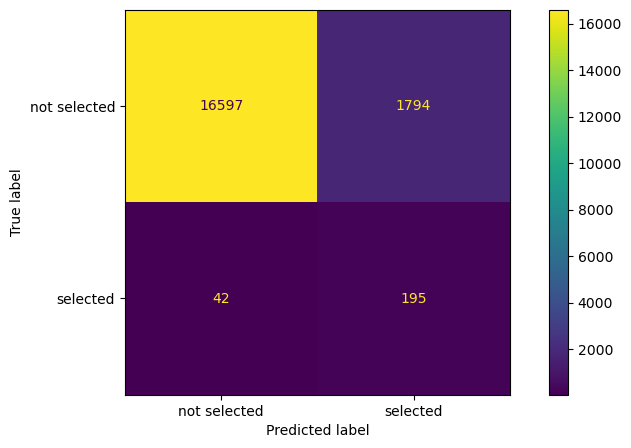

In [112]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
target_names = (['not selected', 'selected'])
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(target_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

In [113]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 


# Confusion Matrix 
cm = confusion_matrix(target_test, pred) 
# Accuracy 
accuracy = accuracy_score(target_test, pred) 
# Precision 
precision = precision_score(target_test, pred) 
# Recall 
recall = recall_score(target_test, pred) 
# F1-Score 
f1 = f1_score(target_test, pred) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(target_test, pred) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1-Score:", f1) 
print("ROC AUC:", roc_auc) 

Confusion Matrix:
[[16597  1794]
 [   42   195]]
Accuracy: 0.9014386944384797
Precision: 0.09803921568627451
Recall: 0.8227848101265823
F1-Score: 0.1752021563342318
ROC AUC: 0.8626185482855194


### Distance and area as a way to find why?

In [114]:
def get_matched_distance(walk_id):
    pois = [str(p) for p in list(walk_pois[walk_pois['walk_id'] == walk_id]['poi_id'])]
    return {p:[osm_paths[osm_paths['poi_id'] == p].distance.min(), 
               osm_paths[osm_paths['poi_id'] == p].apply(lambda row: row['geometry_osm'].length, axis=1).max(),
               osm_paths[osm_paths['poi_id'] == p].apply(lambda row: row['geometry_osm'].area, axis=1).max()
              ] for p in pois if len(osm_paths[osm_paths['poi_id'] == p]) > 0} | \
    {p: [-1,-1,-1] for p in pois if len(osm_paths[osm_paths['poi_id'] == p]) == 0}

def get_nearby_distance(walk_id):
    pois = [str(p) for p in list(walk_pois[walk_pois['walk_id'] == walk_id]['poi_id'])]

    raw_nearby_pois = get_osm_pois_nearby(pois)
    all_results = {}
    for poi_key, raw_nearby_poi_list in raw_nearby_pois.items():
        path_geometry = all_paths_projected[all_paths_projected['poi_id'] == str(poi_key)].geometry
        raw_nearby_poi_list['geometry_path'] = raw_nearby_poi_list.apply(lambda row: path_geometry, axis=1)
        raw_nearby_poi_list['distance'] = raw_nearby_poi_list.apply(lambda row: row['geometry'].distance(row['geometry_path']), axis=1)
        info_list = raw_nearby_poi_list.to_dict(orient='records')
        for info in info_list:
            info_key = str(info['element_type']) + ':' + str(info['osmid'])
            if info_key not in all_poi_matched:
                all_results[info_key] = [info['distance'], info['geometry'].length, info['geometry'].area]
    return all_results
    

In [115]:
get_matched_distance(10)

{'160': [10.710262740263861, 6639.722879262644, 0.0],
 '161': [0.0, 2418.670410630268, 0.0],
 '162': [-1, -1, -1]}

In [116]:
get_nearby_distance(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.68it/s]


{'node:1918054390': [122.58308661341817, 0.0, 0.0],
 'node:3911734368': [136.3045307242034, 0.0, 0.0],
 'way:181376038': [0.0, 1946.747157128005, 0.0],
 'way:553347865': [78.87089906801054, 72.21029164616968, 0.0],
 'way:553347867': [86.10677173284593, 37.74399592681099, 0.0],
 'relation:11692961': [10.099379554248726,
  61466.484546383144,
  135754961.62676498],
 'relation:11693059': [0.0, 67726.82371314286, 135992996.2701828],
 'way:740156404': [0.0, 3504.4463912197507, 0.0],
 'relation:11692962': [0.0, 82675.91808444442, 197114486.85470042]}

In [117]:
%%capture
import os

selecteds_spatial = {}
ignored_spatial = {}

if os.path.isfile('outputs/tmp/selecteds_spatial.json'):
    with open('outputs/tmp/selecteds_spatial.json', encoding='utf-8') as fp:
        selecteds_spatial = json.load(fp)

    with open('outputs/tmp/ignored_spatial.json', encoding='utf-8') as fp:
        ignored_spatial = json.load(fp)
else:
    for w_id in list(walk_pois['walk_id'].unique()):
        logger.info(f'walk id: {w_id}')
        selecteds_spatial = selecteds_spatial | get_matched_distance(w_id)
        ignored_spatial = ignored_spatial | get_nearby_distance(w_id)
    with open('outputs/tmp/selecteds_spatial.json', 'w', encoding='utf-8') as fp:
        json.dump(selecteds_spatial, fp)

    with open('outputs/tmp/ignored_spatial.json', 'w', encoding='utf-8') as fp:
        json.dump(ignored_spatial, fp)

In [118]:
selected_spatial_filtered = [selecteds_spatial[k] for k,v in selecteds.items() if len(v) > 10]
ignored_spatial_filtered = [ignored_spatial[k] for k,v in ignored.items() if len(v) > 10]

print(f'#selected: {len(selected_spatial_filtered)} out of {len(selecteds_spatial)} - #nearby: {len(ignored_spatial_filtered)} out of {len(ignored_spatial)}')

#selected: 2367 out of 4392 - #nearby: 183906 out of 184070


In [119]:
X = selected_spatial_filtered + ignored_spatial_filtered
y = [1 for s in selected_spatial_filtered] + [0 for i in ignored_spatial_filtered]

In [120]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.1, random_state=432, stratify=y)

In [121]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=432)
X_res, y_res = sm.fit_resample(data_train, target_train)

# from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=432)
cv_results = cross_validate(clf, X_res, y_res, cv=10, return_estimator=True)

sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [122]:
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

array([0.86270127, 0.86091895, 0.86064707, 0.86088874, 0.8597106 ,
       0.86067728, 0.85989185, 0.85992206, 0.85430324, 0.86221793])

In [123]:
pred_spatial = clf.predict(data_test)

[Text(0, 0, 'not selected'), Text(0, 1, 'selected')]

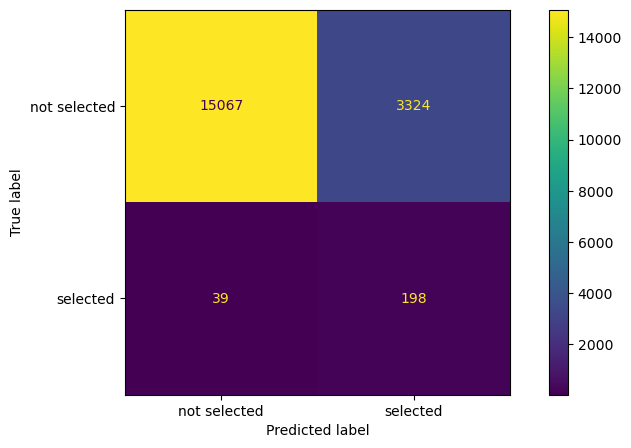

In [124]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
target_names = (['not selected', 'selected'])
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(target_test, pred_spatial, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 


# Confusion Matrix 
cm = confusion_matrix(target_test, pred_spatial) 
# Accuracy 
accuracy = accuracy_score(target_test, pred_spatial) 
# Precision 
precision = precision_score(target_test, pred_spatial) 
# Recall 
recall = recall_score(target_test, pred_spatial) 
# F1-Score 
f1 = f1_score(target_test, pred_spatial) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(target_test, pred_spatial) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1-Score:", f1) 
print("ROC AUC:", roc_auc) 

Confusion Matrix:
[[15067  3324]
 [   39   198]]
Accuracy: 0.8194653210221172
Precision: 0.056218057921635436
Recall: 0.8354430379746836
F1-Score: 0.10534716679968077
ROC AUC: 0.8273512291716711


In [126]:
# todo - check if distance, area and length can define which POI suggestion is also spatially valid!

In [127]:
# combine pred and pred_spatial to form an ensemble model!

In [128]:
y_combined = [min(p, pred_spatial[idx]) for idx, p in enumerate(pred)]

[Text(0, 0, 'not selected'), Text(0, 1, 'selected')]

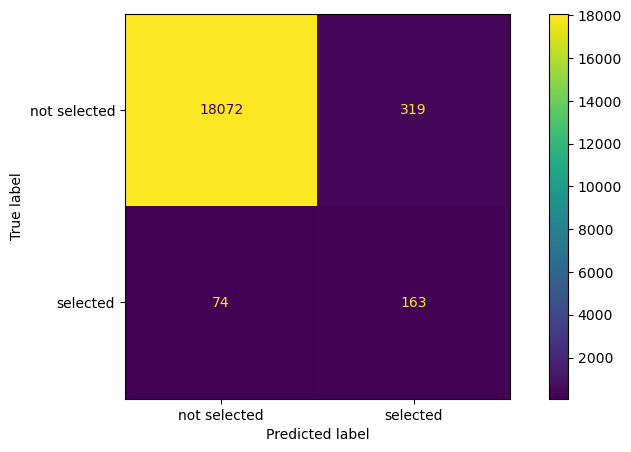

In [129]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
target_names = (['not selected', 'selected'])
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(target_test, y_combined, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

In [130]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 


# Confusion Matrix 
cm = confusion_matrix(target_test, y_combined) 
# Accuracy 
accuracy = accuracy_score(target_test, y_combined) 
# Precision 
precision = precision_score(target_test, y_combined) 
# Recall 
recall = recall_score(target_test, y_combined) 
# F1-Score 
f1 = f1_score(target_test, y_combined) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(target_test, y_combined) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1-Score:", f1) 
print("ROC AUC:", roc_auc) 

Confusion Matrix:
[[18072   319]
 [   74   163]]
Accuracy: 0.9789027270775177
Precision: 0.3381742738589212
Recall: 0.6877637130801688
F1-Score: 0.4534075104311544
ROC AUC: 0.8352091361877382


In [131]:
# add a detailed analysis of method

## POI Classes: Word Clouds

In [19]:
poi_classified['Class'].unique()

array(['nature', 'activities', 'unknown', 'society', 'transport'],
      dtype=object)

In [20]:
poi_classified['Subclass'].unique()

array(['natural landmarks', 'flora and funa', 'sport complexes',
       'fishing to surfing', 'unknown', 'art, history and culture',
       'trail-path-and-canal', 'picnic', 'human made landmarks',
       'food and beverage', 'lines and stations'], dtype=object)

In [21]:
poi_classified_list = poi_classified.to_dict(orient='records')
class_texts = {'nature': [], 'activities': [], 'society': [], 'transport': []}
for row in poi_classified_list:
    if row['Class'] in class_texts.keys():
        class_texts[row['Class']].append(row['document'])

class_texts = {k:' '.join(v) for k,v in class_texts.items()}

In [22]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from string import ascii_letters

def range_alpha(start_letter, end_letter):
  return ascii_letters[
    ascii_letters.index(start_letter):ascii_letters.index(end_letter) + 1
  ]

ulset = range_alpha('a', 'Z')

stopwords = set(STOPWORDS)
stopwords.update(['thi', 'ha', 'wa', 'along', 'walk', 'one', 'two', 'three'])
stopwords.update(ulset)

def generate_wc(text, fig_location=None):
    wordcloud_obj = WordCloud(stopwords=stopwords, background_color="white", max_words=300).generate(text)
    
    plt.imshow(wordcloud_obj, interpolation='bilinear')
    plt.axis("off")
    
    if fig_location is not None:
        plt.savefig(fig_location, bbox_inches='tight')
    plt.show()

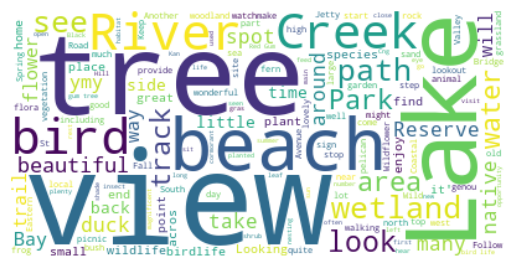

In [23]:
generate_wc(class_texts['nature'], 'outputs/figure/nature_wc.png')

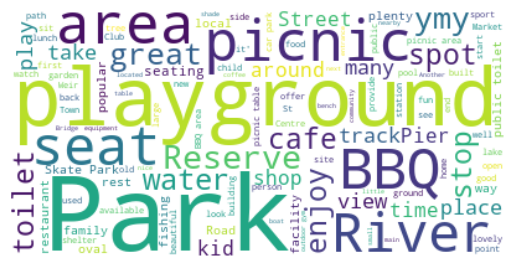

In [24]:
generate_wc(class_texts['activities'], 'outputs/figure/activities_wc.png')

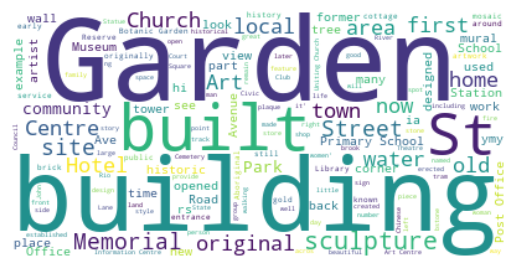

In [25]:
generate_wc(class_texts['society'], 'outputs/figure/society_wc.png')

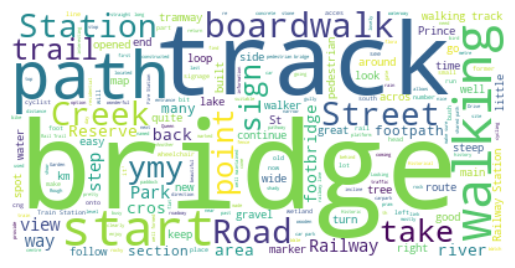

In [26]:
generate_wc(class_texts['transport'], 'outputs/figure/transport_wc.png')

In [45]:
from collections import Counter
import re

# word counts
def word_count(text):
    words = re.findall(r'\w+', text.lower())
    most_commons = [f for f in Counter(words).most_common(100) if f[0] not in stopwords]
    return most_commons[:10]

word_count(class_texts['nature'])

[('view', 281),
 ('tree', 224),
 ('bird', 183),
 ('lake', 182),
 ('river', 165),
 ('beach', 161),
 ('creek', 154),
 ('path', 148),
 ('see', 130),
 ('track', 116),
 ('spot', 111)]

In [46]:
word_count(class_texts['society'])

[('st', 150),
 ('garden', 147),
 ('building', 143),
 ('built', 124),
 ('centre', 117),
 ('art', 114),
 ('church', 103),
 ('street', 81),
 ('memorial', 78),
 ('community', 77),
 ('school', 77)]

In [43]:
word_count(class_texts['activities'])

[('park', 307),
 ('playground', 208),
 ('picnic', 164),
 ('area', 151),
 ('bbq', 120),
 ('spot', 102),
 ('river', 101),
 ('great', 95),
 ('place', 86),
 ('club', 83)]

In [44]:
word_count(class_texts['transport'])

[('bridge', 232),
 ('track', 157),
 ('path', 107),
 ('station', 89),
 ('walking', 83),
 ('railway', 66),
 ('start', 57),
 ('street', 51),
 ('boardwalk', 49),
 ('park', 47)]

## How many walks include each class, subclass of POIs

In [5]:
detailed_list = detailed_df.to_dict(orient='records')
detailed_list[0]

{'index': 0,
 'record_id': 1,
 'record_title': 'Fairhaven to Aireys Inlet Walk created by tedmcrae',
 'record_description': 'Apart from the points of interested listed, here are a few things to keep in mind when taking this walk. 1. Crossing the Great Ocean Road, particularly during summer can be a little perilous. The speed restriction is lowered to 60 kms between November to April. 2. Dogs are prohibited on the beach between December and April. However, this is not well policed by the Surf Coast Shire. Dogs off leash often jump on unsuspecting walkers. 3. Horses on the beach. During the busy summer months, a local horse riding company allows tourists to take horses on the beach to canter. These are inexperienced riders. The horses also defecate so there is a need to be mindful where you step after they have been on the beach.',
 'poi_title': 'Fairhaven Surf Life Saving Club',
 'poi_summary': 'Fairhaven is a well known surf beach. The beach is patrolled during December to the Easter. 

In [6]:
walk_info = {}
for poi_record in detailed_list:
    walk_id = poi_record['record_id']
    if walk_id not in walk_info.keys():
        walk_info[walk_id] = {'class': [], 'subclass': [], 'topic': []}
    walk_info[walk_id]['class'].append(poi_record['Class'])
    walk_info[walk_id]['subclass'].append(poi_record['Subclass'])
    walk_info[walk_id]['topic'].append(poi_record['topic'])
walk_info

{1: {'class': ['nature',
   'nature',
   'nature',
   'nature',
   'nature',
   'nature',
   'activities',
   'activities',
   'unknown',
   'society',
   'transport'],
  'subclass': ['natural landmarks',
   'natural landmarks',
   'flora and funa',
   'natural landmarks',
   'natural landmarks',
   'natural landmarks',
   'sport complexes',
   'fishing to surfing',
   'unknown',
   'art, history and culture',
   'trail-path-and-canal'],
  'topic': [2, 2, 1, 2, 23, 38, 28, 35, 68, 8, 0]},
 2: {'class': ['society',
   'activities',
   'society',
   'society',
   'society',
   'activities',
   'society',
   'society',
   'society',
   'society',
   'society',
   'society',
   'society',
   'society',
   'activities',
   'society',
   'society',
   'society',
   'society',
   'activities',
   'society',
   'society'],
  'subclass': ['art, history and culture',
   'picnic',
   'human made landmarks',
   'human made landmarks',
   'art, history and culture',
   'picnic',
   'human made land

In [13]:
from collections import Counter


def count_and_prec(values):
    values_cnt = Counter(values)
    sum_values_cnt = sum(values_cnt.values())
    return {k : round((v/sum_values_cnt)*100, 1) for k,v in values_cnt.items()}

def compute_metrics(walk_info_record):
    res = {}
    for key, values in walk_info_record.items():
        res[key] = count_and_prec(values)
    return res


compute_metrics(walk_info[1])

{'class': {'nature': 54.5,
  'activities': 18.2,
  'unknown': 9.1,
  'society': 9.1,
  'transport': 9.1},
 'subclass': {'natural landmarks': 45.5,
  'flora and funa': 9.1,
  'sport complexes': 9.1,
  'fishing to surfing': 9.1,
  'unknown': 9.1,
  'art, history and culture': 9.1,
  'trail-path-and-canal': 9.1},
 'topic': {2: 27.3,
  1: 9.1,
  23: 9.1,
  38: 9.1,
  28: 9.1,
  35: 9.1,
  68: 9.1,
  8: 9.1,
  0: 9.1}}

In [15]:
walk_info_metrics = {}
for walk_id, wal_info_record in walk_info.items():
    walk_info_metrics[walk_id] = compute_metrics(wal_info_record)
walk_info_metrics

{1: {'class': {'nature': 54.5,
   'activities': 18.2,
   'unknown': 9.1,
   'society': 9.1,
   'transport': 9.1},
  'subclass': {'natural landmarks': 45.5,
   'flora and funa': 9.1,
   'sport complexes': 9.1,
   'fishing to surfing': 9.1,
   'unknown': 9.1,
   'art, history and culture': 9.1,
   'trail-path-and-canal': 9.1},
  'topic': {2: 27.3,
   1: 9.1,
   23: 9.1,
   38: 9.1,
   28: 9.1,
   35: 9.1,
   68: 9.1,
   8: 9.1,
   0: 9.1}},
 2: {'class': {'society': 81.8, 'activities': 18.2},
  'subclass': {'art, history and culture': 36.4,
   'picnic': 18.2,
   'human made landmarks': 45.5},
  'topic': {65: 4.5,
   31: 13.6,
   60: 13.6,
   10: 4.5,
   11: 22.7,
   8: 18.2,
   13: 4.5,
   7: 4.5,
   6: 4.5,
   48: 4.5,
   22: 4.5}},
 3: {'class': {'activities': 2.6,
   'unknown': 2.6,
   'transport': 2.6,
   'society': 89.5,
   'nature': 2.6},
  'subclass': {'fishing to surfing': 2.6,
   'unknown': 2.6,
   'trail-path-and-canal': 2.6,
   'art, history and culture': 76.3,
   'human made 

In [17]:
class_at_least_one = {}
class_majority = {}
no_majority = []
for walk_id, metrics in walk_info_metrics.items():
    if len([v for v in metrics['class'].values() if v >= 50]) == 0:
        no_majority.append(walk_id)
    for m, value in metrics['class'].items():
        if m not in class_at_least_one.keys():
            class_at_least_one[m] = []
            class_majority[m] = []
        class_at_least_one[m].append(walk_id)
        if value >= 50:
            class_majority[m].append(walk_id)
    
        

In [18]:
len(no_majority)

122

In [19]:
{k:len(v) for k, v in class_majority.items()}

{'nature': 125, 'activities': 63, 'unknown': 2, 'society': 64, 'transport': 12}

In [20]:
{k:len(v) for k, v in class_at_least_one.items()}

{'nature': 338,
 'activities': 315,
 'unknown': 131,
 'society': 256,
 'transport': 238}

# NOTE - TODO list

1. explain how these model works -> contextualize it with respect to the categories identified!
2. derive basic stats of what keys for what subclass/class
3. start comparing key values of selected vs. not selected features: distance to the path, type and OSM information, pattern in not selected - what tags/values?
5. build a binary classifier (both text and feature engineering) to label important or not for leisure walking - create a frequent tag feature dataset and start building a binary classifier - input feature --> is it selected? - then describe what it achieves and how it performs
6. optional: add a text classifier - DNN to show it can be improved by embeddings?

In [170]:
osm_paths[osm_paths['poi_id'] == '162']

,name,osm_key,poi_id,geometry_osm,geometry_path,distance


In [138]:
all_paths_projected[all_paths_projected['poi_id'] == '163']

,poi_id,geometry
163,163,"LINESTRING (321543.356 5811670.276, 321540.836..."
